# Summary statistics for dataset collected in EJP task 7.3

This notebook serves as support for the the manuscript entitled: "An open-source metadataset of running European mid-term and long-term field experiments" by Blanchy et al. (2022). It aims at examining the research theme present in the dataset by comparing the met-data about treatments (=combination of factor levels) for each long-term field experiment.

A simplified version of the dataset can be explored at [https://lte.bonares.de/](https://lte.bonares.de/).

Note: the number of experiments can differ slightly from the ones used in the manuscript because some entries of the database were not made public.

References:
- Alexander Lex, Nils Gehlenborg, Hendrik Strobelt, Romain Vuillemot, Hanspeter Pfister, UpSet: Visualization of Intersecting Sets, IEEE Transactions on Visualization and Computer Graphics (InfoVis ‘14), vol. 20, no. 12, pp. 1983–1992, 2014. doi: [doi.org/10.1109/TVCG.2014.2346248](https://doi.org/10.1109/TVCG.2014.2346248)

In [1]:
import numpy as np  # numeric python
import time  # timing of functions
import pandas as pd  # dataframe manipulation
import matplotlib
import matplotlib.pyplot as plt  # all plots
import matplotlib.patches as mpatches # missing data indicator
from matplotlib.ticker import MaxNLocator, MultipleLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes # missing data indicator
from mpl_toolkits.basemap import Basemap  # map of europe plot
from tqdm import tqdm_notebook as tqdm
from ipyleaflet import Map, basemaps, basemap_to_tiles, Marker
from upsetplot import UpSet  # graph with interactions
import plotly.graph_objects as go  # sankey figure
import warnings
warnings.simplefilter('ignore')
import rasterio  # for completion of soil types based on coordinates

# define function to force casting to float
def f(x):
    try:
        return float(x)
    except:
        return np.nan

# datadir = '/content/drive/MyDrive/ilvo/ejp7.3/processing/data/'
datadir = '../data/'
outputdir = datadir + '../figures/'
redir = datadir + '../output/research-themes/'

letters = 'abcdefghijklmnopqrstuvwxyz'

print('numpy', np.__version__)
print('pandas', pd.__version__)
print('matplotlib', matplotlib.__version__)

numpy 1.26.1
pandas 2.1.1
matplotlib 3.8.0


In [2]:
# load database with levels
dfdic = pd.read_excel(datadir + 'ejp7_3-lte-db-levels-public.xlsx', sheet_name=None, skiprows=[0, 1, 3])

# plot some statistics
print(dfdic['experiment'].shape[0], 'LTEs in total from',
      dfdic['experiment']['Country'].unique().shape[0], 'countries ', end='')
df = dfdic['treatment'].copy()[['Experiment ID', 'Treatment ID']]
df['one'] = 1
print('with {:.0f} treatments (unique combination of factor levels)'.format(
    df.groupby(['Experiment ID', 'Treatment ID']).sum().sum()['one']))

243 LTEs in total from 20 countries with 1612 treatments (unique combination of factor levels)


In [3]:
# filter out experiment younger than 5 years
df = pd.merge(dfdic['experiment'],
            dfdic['treatment'][['Experiment ID', 'Year started']].groupby('Experiment ID').min(),
            on=['Experiment ID'], how='left')

print('total number of LTE:', df.shape[0])
print('LTE older than 20 years:', df['Year started'].le(2000).sum())
print('LTE between 5 and 20 years:', df['Year started'].between(2001, 2015).sum())
print('LTE at least 5 years old:', df['Year started'].le(2015).sum())
print('LTE younger than 5 years old:', df['Year started'].gt(2015).sum())
print('LTE started date unknown:', df['Year started'].isna().sum())

# apply filtering
expids = df[df['Year started'].le(2015)]['Experiment ID'].unique().tolist()
for key in dfdic:
    df = dfdic[key]
    if 'Experiment ID' in df.columns:
        ie = df['Experiment ID'].isin(expids)
        dfdic[key] = df[ie].reset_index(drop=True)

# plot some statistics
print(dfdic['experiment'].shape[0], 'LTEs in total from',
      dfdic['experiment']['Country'].unique().shape[0], 'countries ', end='')
df = dfdic['treatment'].copy()[['Experiment ID', 'Treatment ID']]
df['one'] = 1
print('with {:.0f} treatments (unique combination of factor levels)'.format(
    df.groupby(['Experiment ID', 'Treatment ID']).sum().sum()['one']))

total number of LTE: 243
LTE older than 20 years: 152
LTE between 5 and 20 years: 74
LTE at least 5 years old: 226
LTE younger than 5 years old: 9
LTE started date unknown: 8
226 LTEs in total from 20 countries with 1554 treatments (unique combination of factor levels)


In [4]:
# useful functions
def cleanArrow(x):
    if pd.isna(x):
        return x
    else:
        return x.replace('> ','').replace('>','')


def buildCatDic(s):
    s = s.dropna()
    dic = {}
    cat = s[0]
    for item in s:
        if '>' in item:
            dic.update({item: cat})
        else:
            cat = item
            dic.update({item: cat})
    return dic

def buildCat(s):
    s = s.dropna()
    dic = {}
    cat = s[0]
    for item in s:
        if '>' in item:
            dic.update({item: cat})
        else:
            cat = item
            dic.update({item: cat})
    def func(x):
        if x in dic.keys():
            return dic[x]
        elif pd.isna(x):
            return np.nan
        else:
            return 'unclassified'
    return func

In [5]:
# define crop classses as dictionnary
df = dfdic['crops']
inotmain = df['Crop (l0)'].ne('Main crop')
sdf = df[inotmain][['Crop (l1)', 'Crop (l0)']].drop_duplicates()
cropdic = dict(zip(sdf['Crop (l1)'], sdf['Crop (l0)']))
dic = {
    '> Sugar beet/Beta vulgaris subsp. vulgaris': 'Roots',
    '> Barley/Hordeum vulgare': 'Cereals', 
    '> Rye/Secale cereale': 'Cereals',
    '> Legumes/Pulse': 'Vegetables', 
    '> Wheat/Triticum aestivum': 'Cereals',
    '> Sunflower/Helianthus sp.': 'Others',
    '> Rapeseed/Brassica napus subsp. napus': 'Roots',
    '> Maize/Corn/Zea mays': 'Maize/Corn',
    '> Potato/Solanum tuberosum': 'Potatoes',
    '> Millet': 'Cereals',
    '> Oat/Avena sativa': 'Cereals',
    '> Onion/Allium cepa': 'Vegetables',
    'Grasses': 'Grasses',
    '> Triticale/Ã— Triticosecale': 'Cereals',
    '> Pumpkin/Cucurbita sp.': 'Vegetables',
    '> Celeriac/Apium graveolens var. rapaceum': 'Vegetables',
    '> Leek/Allium ampeloprasum': 'Vegetables',
    '> Lettuce/Lactuca sativa': 'Vegetables',
    '> Savoy cabbage/Brassica oleracea var. sabauda': 'Vegetables',
    '> Hemp/Cannabis sativa': 'Others',
    '> Beets/Chards/Beta vulgaris subsp. vulgaris': 'Roots',
    '> Carrot/Daucus carota subsp. sativus': 'Roots',
    '> Lolium/Ryegrass': 'Grasses',
    '> Festuca/Fescue grass': 'Grasses',
    '> Phleum/Timothy': 'Grasses',
    '> Panicum virgatum/Switchgrass': 'Grasses',
    'Main crop': 'Others',
    '> Durum wheat/Triticum durum': 'Cereals',
    '> Spelt/Triticum spelta': 'Cereals',
    '> Apricot tree/Prunus armeniaca': 'Trees',
    '> Olive/Olea europaea': 'Trees',
    '> Radish/Raphanus sp.': 'Roots',
    '> Acer/Maple': 'Trees',
    '> Almond/Prunus dulcis': 'Trees',
    '> Apple tree/Malus domestica': 'Trees',
    '> Broccoli/Brassica oleracea var. italica': 'Vegetables',
    '> Brussels sprouts/Brassica oleracea var. gemmifera': 'Vegetables',
    '> Cabbage turnip/Brassica oleracea var. gongylodes': 'Vegetables',
    '> Carpinus/Hornbeam': 'Vegetables',
    '> Cauliflower/Brassica oleracea var. botrytis': 'Vegetables',
    '> Corylus/Hazelnut tree': 'Trees',
    '> Cotton plant/Gossypium sp.': 'Others',
    '> Fennel/Foeniculum vulgare': 'Vegetables',
    '> Flax/Linseed/Linum usitatissimum': 'Others',
    '> Grape/Vitis vinifera': 'Trees',
    '> Grapefruit/Citrus Ã— paradisi': 'Trees',
    '> Kiwifruit/Actinidia sp.': 'Trees',
    '> Melon': 'Vegetables',
    '> Nectarine/Prunus persica var. nucipersica': 'Trees',
    '> Pear/Pyrus sp.': 'Trees',
    '> Persimmon/Diospyros sp.': 'Trees',
    '> Phacelia sp.': 'Others',
    '> Mustard': 'Others',
    '> Walnut/Juglans sp.': 'Trees',
    '> Strawberry': 'Vegetables',
    '> Sweet cherry/Prunus avium': 'Trees',
    '> Chicory/Cichorium intybus': 'Others',
    '> Tomato/Solanum lycopersicum': 'Vegetables',
    '> Sweet Orange/Citrus Ã— sinensis': 'Trees',
    '> Spinach/Spinacia oleracea': 'Vegetables',
    '> Citron/Citrus medica': 'Trees',
    '> Turnip/Brassica rapa subsp. rapa': 'Roots',
    '> Rice': 'Cereals',
    '> Celery/Apium graveolens var. graveolens': 'Vegetables',
    '> Kale/Leaf cabbage/Brassica oleracea var. acephala': 'Vegetables',
    '> Gourd/Cucurbita sp.': 'Vegetables',
    'nan': np.nan,
    np.nan: np.nan,
}
cropdic.update(dic)
notinlist = ~df['Crop (l1)'].isin(list(cropdic.keys()))
if notinlist.sum() > 0:
    print("to add to dic:\n'" + "': '',\n'".join(
        df[notinlist]['Crop (l1)'].unique().tolist()) + "': '',")
else:
    print('nothing to add')

def cropClass(x):
    if x in cropdic.keys():
        return cropdic[x]
    else:
        return np.nan
dfdic['crops']['Crop (class)'] = dfdic['crops']['Crop (l1)'].apply(cropClass)

# renaming 'monoculture' to 'monocropping': one crop at the same time for the same space
dfdic['crops'] = dfdic['crops'].replace({'Monoculture': 'Monocropping'})

nothing to add


## Treatment extraction
We extract treatment by comparing the levels (e.g. no-tilage, conventional tillage) within the same factor (e.g. tillage) between two treatments (=unique combination of factor levels). This way we can identify what varies between treatments.

This extraction is *automatic*. The idea is that if two "Treatment ID" have different value for the same columns or different number of rows for the same columns, then this column is what is compared between the two treatments.

In [6]:
# identify which management practice is treatment specific
def extractTreatment(dfdic):
    t0 = time.time()
    sheets = ['treatment', 'crops', 'tillage', 'amendment', 'irrigation', 'pest-weed', 'grazing']
    sheets = [sheet for sheet in sheets if sheet in dfdic.keys()]
    expids = dfdic['experiment']['Experiment ID'].unique()
    x = np.zeros((len(expids), len(sheets)), dtype=bool)
    dft = pd.DataFrame(x, columns=sheets) # True if the practice is part of treatment
    dft.insert(0, 'Experiment ID', expids)
    # dfd to store which columns are making it a treatment
    dfd = dict(zip(dfdic.keys(), []*len(dfdic.keys())))
    ddic = dict(zip(sheets, [0]*len(sheets)))
    for sheet in tqdm(sheets):
        dfdsheet = []  # list of pandas.Series
        df = dfdic[sheet]
        # prepare columns to exclude as probably different between treatment
        # without signication that this is a factor investigated
        cols = df.columns[~df.columns.isin(['Experiment ID', 'Treatment ID', 'Crop ID',
                                            'Publication ID', 'Treatment definition',
                                            'Year started', 'Year ended', 'Reference treatment'])]
        cols = cols[~cols.str.contains('(comment)')]

        # sorting dataframe to ensure similarity when comparing multiple rows
        # of different treatments
        scols = [a for a in ['Experiment ID', 'Treatment ID'] if a in df.columns] + cols.tolist()
        df = df.sort_values(by=scols).reset_index(drop=True)
        vals = df[cols].values  # extract all values as numpy array

        sameRows = True  # flag to know about different number of rows between treatid
        for i, expid in enumerate(tqdm(expids)):
            iexp = df['Experiment ID'] == expid
            sameRows = True  # reset flag

            # define dfd (number > 0 if columns is different between treatid)
            dfdexp = []

            isTreatment = False
            if (iexp.sum() > 0): # sheet might be empty for expid
                treatids = df[iexp]['Treatment ID'].unique()

                # create mask for NaN values and index for each treatid
                ies = np.zeros((df.shape[0], len(treatids)), dtype=bool)
                xs = []  # store values per treatment
                masks = []  # store NaN mask
                for j, treatid in enumerate(treatids):
                    ies[:, j] = df['Treatment ID'].eq(treatid) & iexp
                    x = vals[ies[:, j]]
                    xs.append(x)
                    masks.append(x != x)  # NaN is always different from itself

                # compare all combinations of treatids (upper triangle matrix)
                for j, treatid1 in enumerate(treatids[:-1]):
                    for jj, treatid2 in enumerate(treatids[j+1:]):
                        k = j + 1 + jj

                        # test if same number of rows between the two treatments
                        if ies[:, j].sum() == ies[:, k].sum():

                            # let's check if all the rows are identical between the two treatments
                            imatch = xs[j] == xs[k]
                            inan = masks[j] & masks[k]
                            imatch[inan] = True  # NaN == NaN set to True

                            # if not all values are equal, it's a treatment
                            if imatch.all() == False:
                                isTreatment = True
                                # try to identify which columns make it a treatment
                                # we don't want the column to be chosen because of NaN vs other value
                                inancols = inan.any(0)

                                # we don't want identical columns
                                ieqcols = imatch.all(0)

                                # columns that are different between the 
                                # two treatments ID, excluding all columns
                                # that contains at least one NaN
                                idiff = ~ieqcols & ~inancols
                                dfdexp += cols[idiff].tolist()
                        else:
                            # they don't have the same number of rows
                            isTreatment = True

                            # try to identify which rows makes it a treatment
                            if sameRows:
                                ddic[sheet] += 1
                                sameRows = False

            # create dict for dfd
            s = dict(zip(dfdexp, [1]*len(dfdexp)))
            s['Experiment ID'] = expid
            if sameRows is False:
                s['nrows'] = 1
            dfdsheet.append(s)

            if isTreatment is True:
                dft.loc[dft['Experiment ID'] == expid, sheet] = True

        # create dataframe for dfd
        dfd[sheet] = pd.DataFrame(dfdsheet).fillna(0)
    print('automatic treatment extraction... done ({:.2f}s)'.format(time.time() - t0))

    return dft, dfd, ddic

dft, dfd, ddic = extractTreatment(dfdic)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

automatic treatment extraction... done (8.28s)


33  experiments with different treatments investigating "treatment"
	Different number of rows between treatments: 0
	Crop rotation: 21
	Land use: 13
	Farming system: 12
	Land use (l2): 12
	Land use (l1): 11
	Land use (l0): 1
86  experiments with different treatments investigating "crops"
	Different number of rows between treatments: 42
	Residues removal: 42
	nrows: 42
	Residues incorporation: 37
	Crop: 29
	Crop (l2): 29
	Crop (l1): 29
	Crop (class): 29
	Cropping system (l2): 24
	Cropping system (l1): 24
	Cropping system (l0): 24
	Crop (l0): 24
	Cropping system: 24
	Crop type: 18
	Harvesting frequency: 18
	Harvesting/Termination period: 17
	Sowing method: 16
	Rotation: 16
	Residues burning: 15
	Harvesting/Termination method (l1): 15
	Harvesting/Termination method (l2): 15
	Harvesting/Termination method: 15
	Sowing period: 15
	Harvesting/Termination method (l0): 14
	Re-seeding frequency: 5
69  experiments with different treatments investigating "tillage"
	Different number of rows between

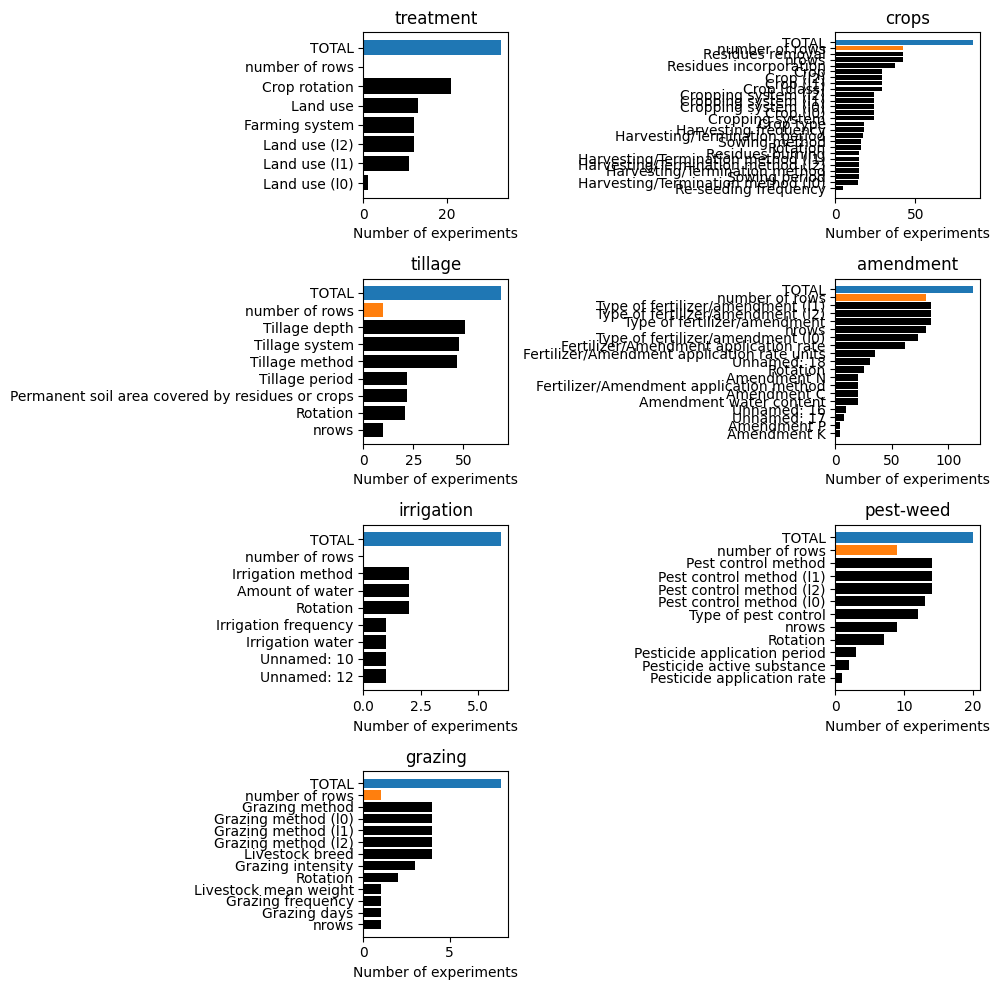

In [7]:
# why are they treatment? (from an automatic perspective)
fig, axs = plt.subplots(4, 2, figsize=(10, 10))
axs = axs.flatten()
for i, key in enumerate(['treatment', 'crops', 'tillage', 'amendment', 'irrigation', 'pest-weed', 'grazing']):
    print('{:<3d} experiments with different treatments investigating "{:s}"'.format(dft[key].sum(), key))
    df = dfd[key]
    dcols = df.columns[~df.columns.isin(['Experiment ID', 'Treatment ID'])]
    dcols = dcols[~dcols.str.contains('comment')]
    s = df[dcols].sum().astype(int).sort_values(ascending=False)
    s = s[s != 0]
    ax = axs[i]
    ax.set_title(key)
    ax.barh(0, dft[key].sum())
    ax.barh(1, ddic[key])
    print('\tDifferent number of rows between treatments: {:d}'.format(ddic[key]))
    for i in range(s.shape[0]):
        print('\t' + s.index[i] + ': ' + str(s[i]))
        ax.barh(i+2, s[i], color='k')
    ax.set_yticks(np.arange(s.shape[0] + 2))
    ax.invert_yaxis()
    ax.set_yticklabels(['TOTAL', 'number of rows'] + s.index.tolist())
    ax.set_xlabel('Number of experiments')
axs[-1].remove()
fig.tight_layout()

## Overview statistics

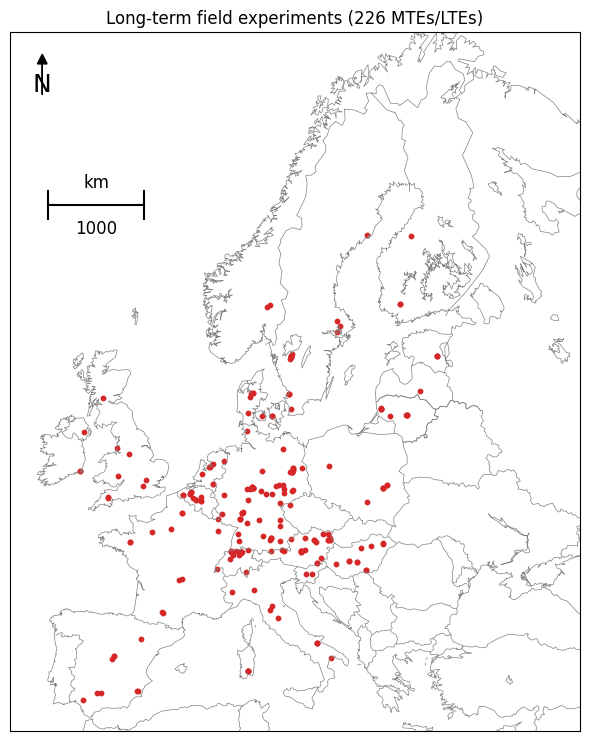

In [8]:
# map of LTE (static)
df = dfdic['experiment']
fig, ax = plt.subplots(figsize=(6, 8))
ax.set_title('Long-term field experiments ({:d} MTEs/LTEs)'.format(df.shape[0]))
m = Basemap(projection='merc', llcrnrlat=35, urcrnrlat=71, 
            llcrnrlon=-13, urcrnrlon=40, resolution='l', ax=ax)
m.drawcoastlines(linewidth=0.5, color='grey')
m.drawcountries(linewidth=0.5, color='grey')
x, y = m(df['Longitude'], df['Latitude'])
m.scatter(x, y, s=10, color='tab:red')
m.drawmapscale(-5, 65, 30, 39, 1000, fontsize=12)
x, y = m(-10, 69)
x2, y2 = m(-10, 70)
ax.arrow(x, y, x2-x, y2-y, fc='k', ec='k',
         head_width=100000, head_length=100000)
ax.text(x, y+(y2-y)*0.1, 'N', fontsize=18, ha='center')
fig.tight_layout()
fig.savefig(outputdir + 'lte-map.jpg', dpi=300)

1.8636362552642822
6.392958879470825
0.07280921936035156


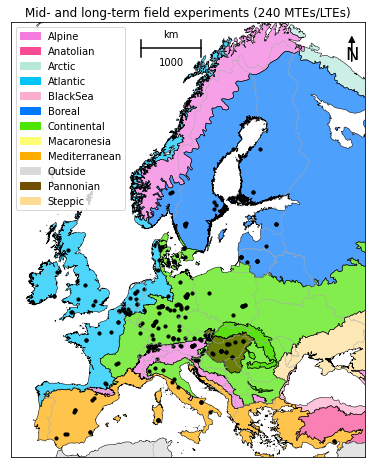

In [27]:
# with environmental zones
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title('Mid- and long-term field experiments ({:d} MTEs/LTEs)'.format(df.shape[0]))
m = Basemap(projection='merc', llcrnrlat=35, urcrnrlat=71, 
            llcrnrlon=-13, urcrnrlon=40, resolution='l', ax=ax)
t0 = time.time()
m.readshapefile(datadir + 'biogeo-regions/biogeoRegions2016-epsg4326-simplified', 'enz')
print(time.time() - t0); t0 = time.time()

import matplotlib.patches as mpatches
colors = {
    'Alpine': '#F37ADE',
    'Anatolian': '#F84B93', 
    'Arctic': '#B7E9DB', 
    'Atlantic': '#01C5F9', 
    'BlackSea': '#FBADCE', 
    'Boreal': '#0179FD',
    'Continental': '#4DE601', 
    'Macaronesia': '#FEFB75', 
    'Mediterranean': '#FFAC00', 
    'Outside': '#D9D9D9',
    'Pannonian': '#705000', 
    'Steppic': '#FDDD96',
}

def PolyArea(xy):
    x = xy[:, 0]
    y = xy[:, 1]
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

shapes = {}
for info, shape in zip(m.enz_info, m.enz):
    if PolyArea(np.array(shape)) > 10000000:  # don't draw small polygon (save a lot of time!)
        p = mpatches.Polygon(np.array(shape), True, facecolor=colors[info['code']], 
                             edgecolor='none', alpha=0.7, zorder=0)
        ax.add_patch(p)
print(time.time() - t0); t0 = time.time()

# add countries
m.drawcountries(linewidth=0.5, color='darkgrey')

# add locations
x, y = m(df['Longitude'], df['Latitude'])
m.scatter(x, y, s=10, color='k')
m.drawmapscale(11, 69.7, 30, 39, 1000, fontsize=10)
x, y = m(38, 69)
x2, y2 = m(38, 70)
ax.arrow(x, y, x2-x, y2-y, fc='k', ec='k',
         head_width=100000, head_length=100000)
ax.text(x, y+(y2-y)*0.1, 'N', fontsize=18, ha='center')

# create legend
handles = [mpatches.Patch(color=colors[key], label=key) for key in colors]
ax.legend(handles=handles)
print(time.time() - t0)

fig.savefig(outputdir + 'lte-map.jpg', dpi=300)

In [10]:
mpatches.Polygon(

SyntaxError: incomplete input (1320754334.py, line 1)

1.4906346797943115
3.640002489089966
0.04781532287597656


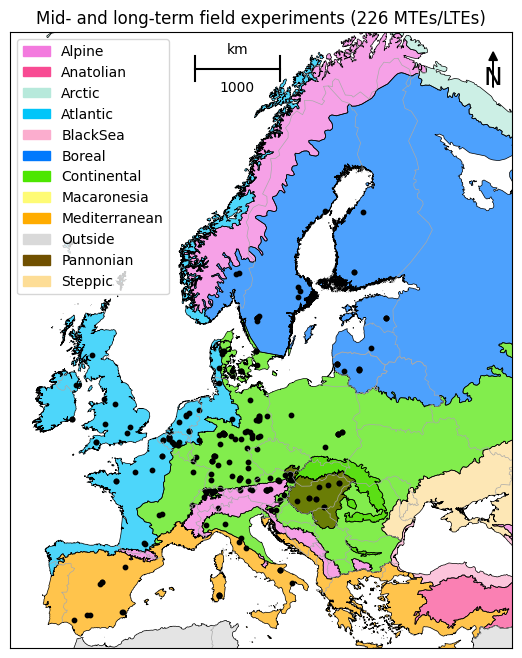

In [11]:
# with environmental zones
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title('Mid- and long-term field experiments ({:d} MTEs/LTEs)'.format(df.shape[0]))
m = Basemap(projection='merc', llcrnrlat=35, urcrnrlat=71, 
            llcrnrlon=-13, urcrnrlon=40, resolution='l', ax=ax)
t0 = time.time()
m.readshapefile(datadir + 'biogeo-regions/biogeoRegions2016-epsg4326-simplified', 'enz')
print(time.time() - t0); t0 = time.time()

import matplotlib.patches as mpatches
colors = {
    'Alpine': '#F37ADE',
    'Anatolian': '#F84B93', 
    'Arctic': '#B7E9DB', 
    'Atlantic': '#01C5F9', 
    'BlackSea': '#FBADCE', 
    'Boreal': '#0179FD',
    'Continental': '#4DE601', 
    'Macaronesia': '#FEFB75', 
    'Mediterranean': '#FFAC00', 
    'Outside': '#D9D9D9',
    'Pannonian': '#705000', 
    'Steppic': '#FDDD96',
}

def PolyArea(xy):
    x = xy[:, 0]
    y = xy[:, 1]
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

shapes = {}
for info, shape in zip(m.enz_info, m.enz):
    if PolyArea(np.array(shape)) > 10000000:  # don't draw small polygon (save a lot of time!)
        p = mpatches.Polygon(np.array(shape), closed=True, facecolor=colors[info['code']], 
                             edgecolor='none', alpha=0.7, zorder=0)
        ax.add_patch(p)
print(time.time() - t0); t0 = time.time()

# add countries
m.drawcountries(linewidth=0.5, color='darkgrey')

# add locations
x, y = m(df['Longitude'], df['Latitude'])
m.scatter(x, y, s=10, color='k')
m.drawmapscale(11, 69.7, 30, 39, 1000, fontsize=10)
x, y = m(38, 69)
x2, y2 = m(38, 70)
ax.arrow(x, y, x2-x, y2-y, fc='k', ec='k',
         head_width=100000, head_length=100000)
ax.text(x, y+(y2-y)*0.1, 'N', fontsize=18, ha='center')

# create legend
handles = [mpatches.Patch(color=colors[key], label=key) for key in colors]
ax.legend(handles=handles)
print(time.time() - t0)

fig.savefig(outputdir + 'lte-map.jpg', dpi=300)

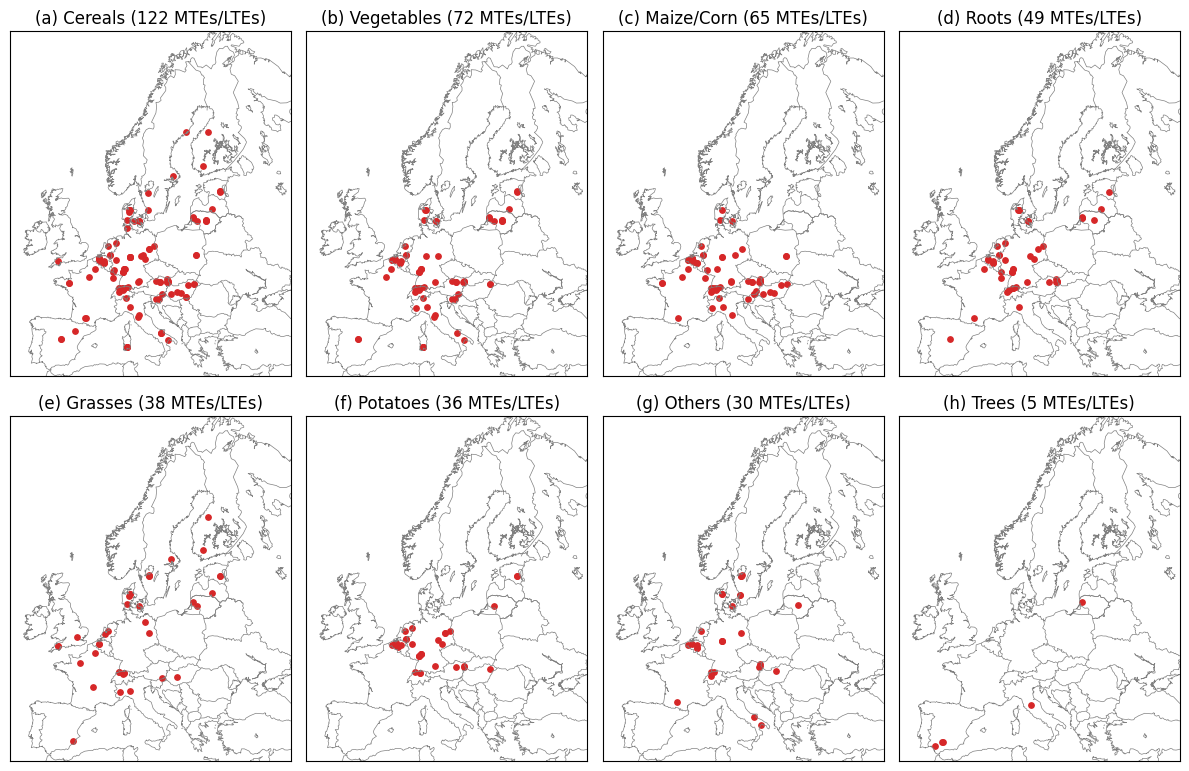

In [12]:
# map of major crop groups
df = dfdic['crops']
df = df.groupby(['Experiment ID', 'Crop (class)']).first().reset_index()
df = pd.merge(df, dfdic['experiment'][['Experiment ID', 'Latitude', 'Longitude']],
              on='Experiment ID')
s = df['Crop (class)'].value_counts()

fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(12, 8))
axs = axs.flatten()
for i in range(s.shape[0]):
    ie = df['Crop (class)'].eq(s.index[i])
    ax = axs[i]
    ax.set_title('({:s}) {:s} ({:d} MTEs/LTEs)'.format(
        letters[i], s.index[i], ie.sum()))
    m = Basemap(projection='merc', llcrnrlat=35, urcrnrlat=71, 
                    llcrnrlon=-13, urcrnrlon=40, resolution='l', ax=ax)
    m.drawcoastlines(linewidth=0.5, color='grey')
    m.drawcountries(linewidth=0.5, color='grey')
    x, y = m(df[ie]['Longitude'], df[ie]['Latitude'])
    m.scatter(x, y, s=15, color='tab:red')
fig.tight_layout()
fig.savefig(outputdir + 'map-crop-class.jpg', dpi=500)

experiment with different starting date per treatment: 22


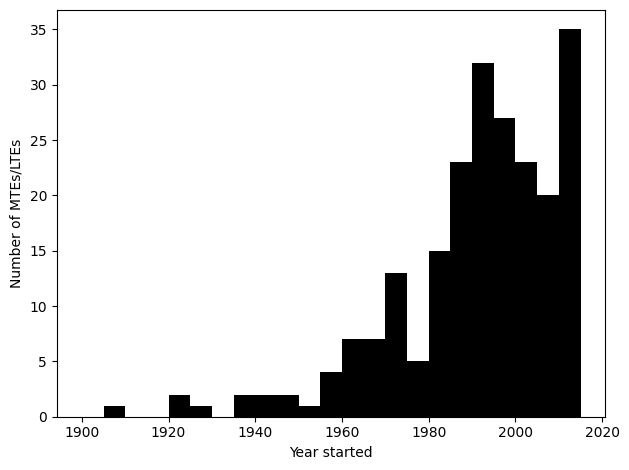

In [14]:
# start of treatments

# to count how many experiments have mixed starting date
df = dfdic['treatment'].groupby('Experiment ID').mean(numeric_only=True)
a = df['Year started'] - df['Year started'].round(0)
print('experiment with different starting date per treatment: {:d}'.format(
        a.ne(0).sum()))

# if mixed starting date, we take the minium date
df = dfdic['treatment'].groupby('Experiment ID').agg({'Year started': 'min'})

bins = np.arange(1900, 2020, 5)
fig, ax = plt.subplots()
df['Year started'].hist(ax=ax, bins=bins, grid=False, color='k')
ax.set_ylabel('Number of MTEs/LTEs')
ax.set_xlabel('Year started')
fig.tight_layout()
fig.savefig(outputdir + 'lte-starting-date.jpg', dpi=300)

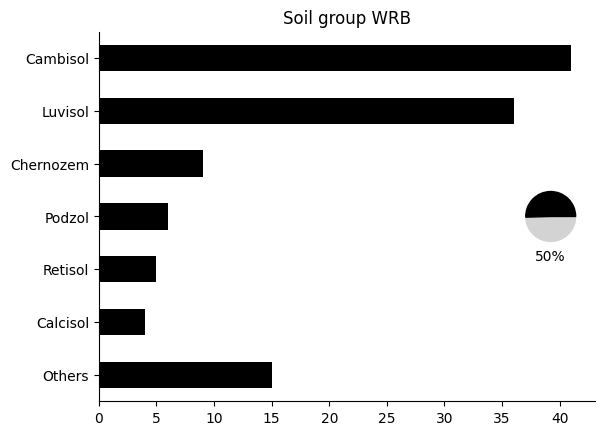

In [16]:
# functions for plotting data and it's availability in the dataset
def plotBar(dfdic, sheet, gcol, title, top=6, expids=[], color='k',
            ax=None, avai=True, xlabel=None):
    """Plot barplot.
    """
    df = dfdic[sheet].copy()
    if len(expids) > 0:
        df = df[df['Experiment ID'].isin(expids)].reset_index(drop=True)
    else:
        expids = dfdic['experiment'].values.tolist()
    df[gcol] = df[gcol].apply(cleanArrow)

    # grouping per expid and gcol, we keep NaN in so we do not drop any expid
    df = df.groupby(['Experiment ID', gcol], dropna=False).first().reset_index()

    # we group by expid only and take the first without dropping NaN
    # this assess data availability in terms of number of LTE
    dflte = df.groupby(['Experiment ID'], dropna=False).first().reset_index()
    available = (dflte[gcol].notnull().sum()) / len(expids)

    # create value_counts() pandas.Series (drops NaN by default)
    s = df[gcol].value_counts()

    # group the 'others' at the end
    if top > s.shape[0]:
        top = s.shape[0]
    if s[top:].sum() > 0:
        soth = pd.Series([s[top:].sum()], index=['Others'])
        s2 = pd.concat([s[:top], soth], axis=0)
    else:
        s2 = s
    s2 = s2[::-1]

    # main bar plot
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_title(title)
    cax = s2.plot.barh(ax=ax, color=color)
    #print(s2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.set_xlim([None, s2.max()*1.15])
    if xlabel is not None:
        ax.set_xlabel(xlabel)

    # data availability indicator
    if avai:
        #print('{:.1f}% data available ({:s})'.format(available*100, gcol))
        ax2 = inset_axes(ax, width='15%', height='15%', loc=7)
        ax2.add_patch(mpatches.Wedge((0, 0), 0.9, 360*available, 0, color='lightgrey'))
        ax2.add_patch(mpatches.Wedge((0, 0), 0.9, 0, 360*available, color=color))
        ax2.set_xlim([-1, 1])
        ax2.set_ylim([-1, 1])
        ax2.set_aspect('equal')
        ax2.set_xlabel('{:.0f}%'.format(available*100))
        ax2.spines['top'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.spines['bottom'].set_visible(False)
        ax2.set_xticks([])
        ax2.set_yticks([])

# test
plotBar(dfdic, 'soil-type', 'Soil group WRB', 'Soil group WRB', top=6, avai=True)
#plotBar(dfdic, 'treatment', 'Farming system', 'Farming system', top=6, avai=True)
#plotBar(dfdic, 'tillage', 'Tillage system', 'test', top=6, avai=True)
#plotBar(dfdic, 'soil-crop-measurement', 'Measurement (l0)', 'test', top=10, avai=True)
#plotBar(dfdic, 'experiment', 'Climatic zone', 'Climatic zone', top=6)

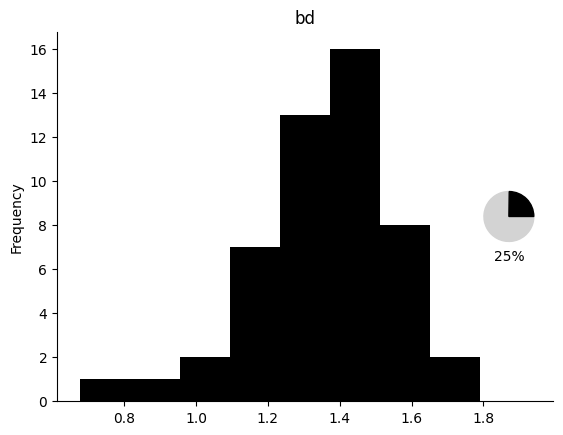

In [17]:
# plot histogram and their data availability
def plotHist(dfdic, sheet, gcol, title, expids=[], color='k',
             ax=None, avai=True, xlabel=None, bins=None):
    """Plot histogram.
    """
    df = dfdic[sheet].copy()
    if len(expids) > 0:
        df = df[df['Experiment ID'].isin(expids)].reset_index(drop=True)
    else:
        expids = dfdic['experiment'].values.tolist()
    def f(x):
        try:
            return float(x)
        except:
            return np.nan
    df[gcol] = df[gcol].apply(f).astype(float)

    # grouping per expid and gcol, we keep NaN in so we do not drop any expid
    df = df.groupby(['Experiment ID'], dropna=False).mean(numeric_only=True).reset_index()

    # we group by expid only and take the first without dropping NaN
    # this assess data availability in terms of number of LTE
    # .first() will return the first NOT NaN element of the group
    dflte = df.groupby(['Experiment ID'], dropna=False).first().reset_index()
    available = (dflte[gcol].notnull().sum()) / len(expids)

    # histogram
    if ax is None:
        fig, ax = plt.subplots()
    if bins is None:
        bins = np.linspace(df[gcol].quantile(0.05),
                           df[gcol].quantile(0.95), 10)
    ax.set_title(title)
    df[gcol].plot.hist(ax=ax, color=color, bins=bins)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.set_xlim([None, s2.max()*1.15])
    if xlabel is not None:
        ax.set_xlabel(xlabel)

    # data availability indicator
    if avai:
        #print('{:.1f}% data available ({:s})'.format(available*100, gcol))
        ax2 = inset_axes(ax, width='15%', height='15%', loc=7)
        ax2.add_patch(mpatches.Wedge((0, 0), 0.9, 360*available, 0, color='lightgrey'))
        ax2.add_patch(mpatches.Wedge((0, 0), 0.9, 0, 360*available, color=color))
        ax2.set_xlim([-1, 1])
        ax2.set_ylim([-1, 1])
        ax2.set_aspect('equal')
        ax2.set_xlabel('{:.0f}%'.format(available*100))
        ax2.spines['top'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.spines['bottom'].set_visible(False)
        ax2.set_xticks([])
        ax2.set_yticks([])

# test
plotHist(dfdic, 'soil-type', 'Soil bulk density (t0)', 'bd', avai=True)
#plotHist(dfdic, 'soil-type', 'Soil organic carbon (t0)', 'soc', avai=True)
#plotHist(dfdic, 'tillage', 'Tillage depth', 'tillage depth', avai=True)
#plotHist(dfdic, 'soil-type', 'Soil pH (t0)', 'pH', avai=True)

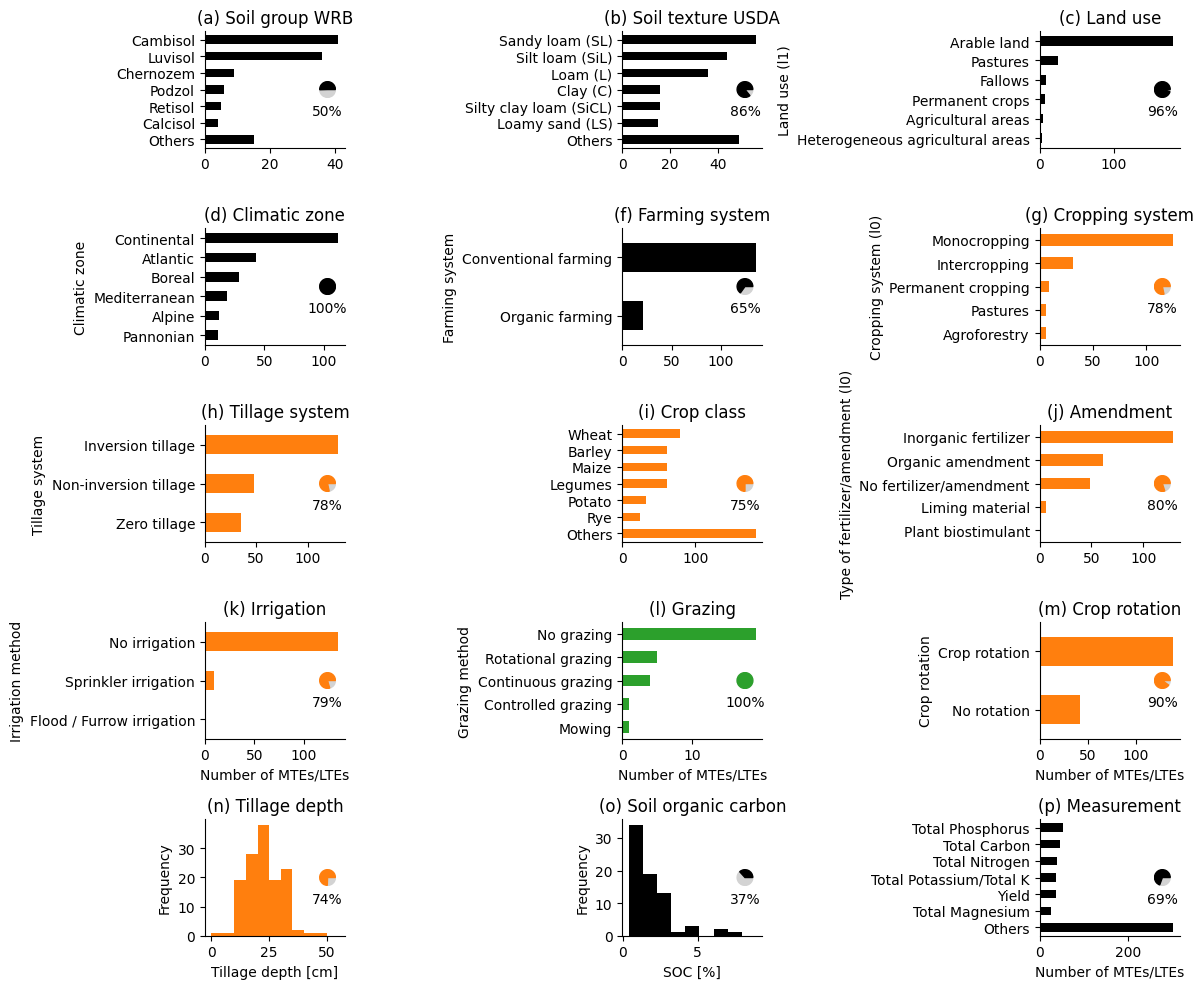

In [18]:
# figure of descriptive statistics
dftreat = dfdic['treatment']
arableId = dftreat[dftreat['Land use (l1)'].eq('> Arable land')]['Experiment ID'].unique().tolist()
pastureId = dftreat[dftreat['Land use (l1)'].eq('> Pastures')]['Experiment ID'].unique().tolist()

fig, axs = plt.subplots(5, 3, figsize=(12, 10))
axs = axs.flatten()
plotBar(dfdic, 'soil-type', 'Soil group WRB', '(a) Soil group WRB', top=6, ax=axs[0])
plotBar(dfdic, 'soil-type', 'Soil texture USDA', '(b) Soil texture USDA', top=6, ax=axs[1])
plotBar(dfdic, 'treatment', 'Land use (l1)', '(c) Land use', top=6, ax=axs[2])
plotBar(dfdic, 'experiment', 'Climatic zone', '(d) Climatic zone', top=6, ax=axs[3])

plotBar(dfdic, 'treatment', 'Farming system', '(f) Farming system', top=6, ax=axs[4])
plotBar(dfdic, 'crops', 'Cropping system (l0)', '(g) Cropping system', top=6, expids=arableId, color='tab:orange', ax=axs[5])
plotBar(dfdic, 'tillage', 'Tillage system', '(h) Tillage system', top=6, expids=arableId, color='tab:orange', ax=axs[6])
plotBar(dfdic, 'crops', 'Crop (l1)', '(i) Crop class', top=6, expids=arableId, color='tab:orange', ax=axs[7])
axs[7].set_yticklabels([a.get_text().split('/')[0] for a in axs[7].get_yticklabels()])


plotBar(dfdic, 'amendment', 'Type of fertilizer/amendment (l0)', '(j) Amendment', top=6, expids=arableId, color='tab:orange', ax=axs[8])
plotBar(dfdic, 'irrigation', 'Irrigation method', '(k) Irrigation', top=6, expids=arableId, color='tab:orange', ax=axs[9], xlabel='Number of MTEs/LTEs')
plotBar(dfdic, 'grazing', 'Grazing method', '(l) Grazing', top=6, expids=pastureId, color='tab:green', ax=axs[10], xlabel='Number of MTEs/LTEs')
#plotBar(dfdic, 'pest-weed', 'Pest control method (l0)', '(m) Pest/weed control', top=6, expids=arableId, color='tab:orange', ax=axs[11], xlabel='Number of LTE')
plotBar(dfdic, 'treatment', 'Crop rotation', '(m) Crop rotation', top=6, expids=arableId, color='tab:orange', ax=axs[11], xlabel='Number of MTEs/LTEs')

# numerical variables
bins = np.arange(0, 60, 5)
plotHist(dfdic, 'tillage', 'Tillage depth', '(n) Tillage depth', bins=bins, expids=arableId, color='tab:orange', ax=axs[12], xlabel='Tillage depth [cm]', avai=True)
#plotHist(dfdic, 'soil-type', 'Soil bulk density (t0)', 'Bulk density', xlabel='Bulk density [g.cm$^{-3}$] avai=True)
plotHist(dfdic, 'soil-type', 'Soil organic carbon (t0)', '(o) Soil organic carbon', ax=axs[13], xlabel='SOC [%]', avai=True)
#plotHist(dfdic, 'soil-type', 'Soil pH (t0)', '(p) pH', xlabel='pH', ax=axs[14], avai=True)
plotBar(dfdic, 'soil-crop-measurement', 'Measurement (l1)', '(p) Measurement', ax=axs[14], top=6, avai=True, xlabel='Number of MTEs/LTEs')

fig.tight_layout()
fig.savefig(outputdir + 'barh-overview.jpg', dpi=500)

## Major practices
- what has been investigated per experiment?
- what are the characteristics of the treatments?

Note that we might have no experiment that investigated irrigation but we might have LTE that were irrigated.
This figure number are in terms of treatment not in terms of LTE as one LTE can have several treatments with different practices.

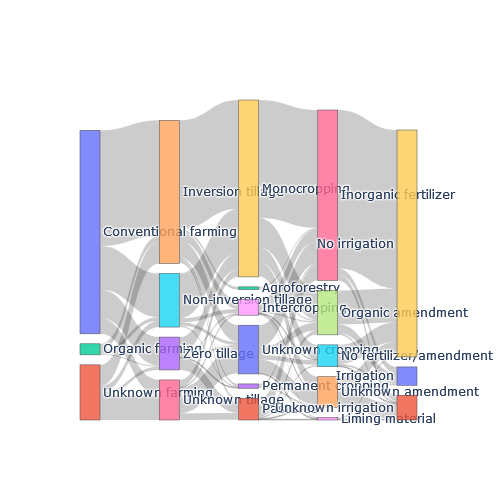

In [20]:
# treatment structure
# just joining per lte (left) can happen but then we will have a mix of different
# number of rows per LTE so better stick with treatments

# farming system
df = dfdic['treatment'][['Experiment ID', 'Treatment ID', 'Farming system']]
df['Farming system'] = df['Farming system'].fillna('Unknown farming')

# tillage
dftill = dfdic['tillage'][['Experiment ID', 'Treatment ID', 'Tillage system']]
dftill = dftill.fillna('Unknown tillage').replace({'-': 'Unknown tillage'})
df = pd.merge(df, dftill, how='left')

# cropping systems
df1 = dfdic['crops'][['Experiment ID', 'Treatment ID', 'Cropping system (l0)']]
df1 = df1.rename(columns={'Cropping system (l0)': 'Cropping system'})
df1 = df1.groupby(['Experiment ID', 'Treatment ID']).first().reset_index()  # assumption
df = pd.merge(df, df1, how='left')
df['Cropping system'] = df['Cropping system'].fillna('Unknown cropping')

# amendment (at least one organic vs only mineral)
df1 = dfdic['amendment'][['Experiment ID', 'Treatment ID', 'Type of fertilizer/amendment (l0)']]
df1 = df1.groupby(['Experiment ID', 'Treatment ID']).first().reset_index()
df = pd.merge(df, df1, how='left').rename(
    columns={'Type of fertilizer/amendment (l0)': 'Amendment'})
df['Amendment'] = df['Amendment'].fillna('Unknown amendment')


# irrigation
df1 = dfdic['irrigation'][['Experiment ID', 'Treatment ID', 'Irrigation method']]
df1 = df1.groupby(['Experiment ID', 'Treatment ID']).first().reset_index()
df = pd.merge(df, df1, how='left')
def func(a):
    dico = {
        None: 'Unknown irrigation',
        np.nan: 'Unknown irrigation',
        'Sprinkler irrigation': 'Irrigation',
        'No irrigation': 'No irrigation',
        'Drip irrigation': 'Irrigation',
        'Flood / Furrow irrigation': 'Irrigation',
    }
    if a in dico.keys():
        return dico[a]
    else:
        return a
df['Irrigation method'] = df['Irrigation method'].apply(func)

# pest/weed (too few entries)
# irrigation (too few entries)


# building edge and node matrix
cols = df.columns[2:]
uvals = np.hstack([df[col].unique() for col in cols])
nodedic = dict(zip(uvals, np.arange(len(uvals))))
edges = []
edgedic = {'source': [], 'target': [], 'value': []}
nodec = 0
for i in range(len(cols) - 1):
    sdf = df[[cols[i], cols[i+1]]]
    sdf['one'] = 1
    dfc = sdf.groupby([cols[i], cols[i+1]]).count().reset_index()
    dfc['one'] = (dfc['one']/dfc['one'].sum()*100).round(1)
    for j in range(dfc.shape[0]):
        row = dfc.loc[j, :]
        edges.append((nodedic[row[cols[i]]], nodedic[row[cols[i+1]]], row['one']))
        edgedic['source'].append(nodedic[row[cols[i]]])
        edgedic['target'].append(nodedic[row[cols[i+1]]])
        edgedic['value'].append(row['one'])


# plotly figure
fig = go.Figure(go.Sankey(
    arrangement = "snap",
    node = {
        "label": list(nodedic.keys()),
        #"x": [0.2, 0.1, 0.5, 0.7, 0.3, 0.5],
        #"y": [0.7, 0.5, 0.2, 0.4, 0.2, 0.3],
        'pad':10},  # 10 Pixels
    link = edgedic))
fig.update_layout(height=500)

# save as picture
fig.write_image(outputdir + 'sankey-practices.jpg', width=800, scale=5)
fig.show()

## Research themes

In this section, we identify LTE that investigate a common research theme (e.g. tillage). We analysize the interaction between the treatments of these LTE (upset plot with dots and two bar charts) and we show in which pedo-climatic conditinos these LTE are run. This helps to identify how widespread a reasearch theme is, if the LTEs are mostly concentrated in a specific country or in a specific climate. It also gives us insights into what is compared against what, which levels are investigated (e.g. no-tillage vs conventional tillage, reduced tillage vs conventional tillage).

In [25]:
# advanced treatment extraction

# Pairwise strategy:
# - filters: conditions to be applied (list of choices to keep or range of numerical values to keep)
# - inclusion of 'Rotation' in conditions or not:
#     - inclusion: comparison will be done if all the year in the rotation met the conditions
#     - not included: comparison will be done if at least one year in the rotation met the conditions
# - value: choice or boolean rules if numeric values
# - occurence (of a value):
#     - -1: neglect this parameter and compare the value vs other values
#     - 0: compare the 0 occurence vs > 0 occurence (at least one occurence)
#     - 1: compare the 1 occurence vs > 1 occurence (hence neglecting the 0 occurence)
# - conditions:
#     - column name and value: only the row with where this column has this value will be considered in the comparison
#     - column name and 'identical': comparison between two rows will only be considered if the value in this column are the same between the two rows compared

queries = {
    # 'inversion tillage vs other': {
    #     'sheet': 'tillage',
    #     'column': 'Tillage system',
    #     'value': 'Inversion tillage',
    #     'occurence': -1,
    #     'conditions': [],
    # },
    'cover crop vs no cover crops': {
        'sheet': 'crops',
        'column': 'Crop type',
        'value': 'Cover crop',
        'occurence': 0,
        'conditions': [('tillage', 'Tillage system', None)],
    },
    # 'one main crop vs double cropping': {
    #     'sheet': 'crops',
    #     'column': 'Crop type',
    #     'value': 'Main crop',
    #     'occurence': 1,
    #     'conditions': [('crops', 'Cropping system', 'Monoculture'),
    #                    ('crops', 'Rotation', None)]
    # },
    # 'cover crop X vs cover crops Y': {
    #     'sheet': 'crops',
    #     'column': 'Crop',
    #     'value': '>> Clover/Trifolium sp.',
    #     'occurence': -1,
    #     'conditions': [('crops', 'Crop type', 'Cover crop'),
    #                    ('crops', 'Rotation', None)]
    # },
    # 'different termination method': {
    #     'sheet': 'crops',
    #     'column': 'Harvesting/Termination method',
    #     'value': '> Frost-killed',
    #     'occurence': -1,
    #     'conditions': [('crops', 'Crop type', 'Cover crop')]
    # },
    # 'different growing period': {
    #     'sheet': 'crops',
    #     'column': 'Sowing period',
    #     'value': 'March',
    #     'occurence': -1,
    #     'conditions': [('crops', 'Crop type', 'Cover crop')]
    # },
    # 'residues incorporated vs residue left on surface': {
    #     'sheet': 'crops',
    #     'column': 'Residues removal',
    #     'value': 'Full residue removal',
    #     'occurence': -1,
    #     'conditions': [('crops', 'Crop', None),
    #                    ('crops', 'Crop type', 'Main crop')]
    # }
}

def extractQueries(queries, dfdic, debug=False):
    # create dataframe to store the pairwise comparison
    dft = dfdic['treatment'][['Experiment ID', 'Treatment ID']].copy()
    compdict = {}
    def dump(*args):
        if debug:
            print(*args)
        else:
            pass

    for key in tqdm(queries):
        # define query
        query = queries[key]
        compdict[key] = []

        # create empty columns with 0 for pairwise
        pcColumn = 'pc-' + key.replace(' ', '_')
        dft[pcColumn] = 0

        # extract the conditions on values and build filtered df for tab
        df = dfdic[query['sheet']]
        i2keep = np.ones(df.shape[0], dtype=bool)
        sameCols = []  # list of column that must be similar between pairwise
        crossCols = []  # list of column similar but in other sheets
        for row in query['conditions']:
            if row[0] == query['sheet']:
                val = row[2]
                if val is None:
                    sameCols.append(row[1])
                else:
                    i2keep = i2keep & df[row[1]].eq(val)
            else:
                crossCols.append((row[0], row[1], row[2]))
        df = df[i2keep].reset_index(drop=True)
        dfcross = pd.DataFrame(crossCols, columns=['sheet', 'column', 'value'])

        # add Rotation year if not in df (to make the code more flexible)
        if 'Rotation' not in df.columns:
            df['Rotation'] = 'year0'

        # columns to use for pairwise comparison
        col = query['column']
        cols = [col] + sameCols

        # cannot compare number 1 vs multiple accross rotation but only inside
        if (query['occurence'] >= 1) & ('Rotation' not in cols):
            cols.append('Rotation')
            print('WARNING: cannot compare number 1 vs multiple accross rotation but only inside rotation')

        # identify rows which are equal to query value
        iref = df[col] == query['value']

        # repeat for each experiment in the tab
        expids = df['Experiment ID'].unique()
        for expid in tqdm(expids):
            ie = df['Experiment ID'] == expid
            treatids = df[ie]['Treatment ID'].unique()
            dump('||| expid: ' + str(expid) + ' with {:d} treatids'.format(len(treatids)))

            # only investigate expid where the query value is present
            if (ie & iref).sum() > 0:

                # first loop looks for the reference/control treatment
                for i, treatid1 in enumerate(treatids):
                    itreat1 = ie & df['Treatment ID'].eq(treatid1)

                    # get the potential rows which contain the control values
                    icontrol = itreat1 & iref

                    controlFound = False
                    # if there is at least one occurence value vs other value)
                    if query['occurence'] < 0:
                        if np.sum(icontrol) > 0:
                            controlFound = True

                    # if there is presence or absence
                    elif query['occurence'] == 0:
                        #print('occ0', treatid1, irows, end='')
                        # for this to be a control, none of the rows should contain the value
                        if np.sum(icontrol) == 0:
                            controlFound = True

                    # if there is the exact number of occurence specified (within a rotation)
                    else:
                        # compute number of occurence of the control within a rotation year
                        icounts = df[icontrol].groupby('Rotation').count()
                        if query['occurence'] in icounts.loc[:, icounts.columns[0]].to_list():
                            controlFound = True

                    if controlFound:
                        dump('\tcontrol found ({:s}) with value:'.format(str(treatid1)),
                            df[itreat1][cols].values.tolist())

                        # once reference is found, look for the corresponding treatments
                        for j, treatid2 in enumerate(treatids):
                            itreat2 = ie & df['Treatment ID'].eq(treatid2)

                            # don't look into the same treatment already selected as control (j != i)
                            # don't look into treatment if it contains NaN for the column of interest
                            # don't look into treatment if it does not contain the value (occurence = 0)
                            if ((j != i) & (df[itreat2][col].isna().sum() == 0)
                                & (((query['occurence'] == 0) 
                                        & (df[itreat2][col].eq(query['value']).sum() > 1))
                                    | (query['occurence'] != 0))):

                                # check if treat2 satisfy the crossCols conditions (same columns in different sheets)
                                condCross = True
                                for csheet in dfcross['sheet'].unique():
                                    ic = dfcross['sheet'] == csheet
                                    scols = dfcross[ic]['column'].tolist()
                                    cdf = dfdic[csheet]
                                    df1 = cdf[cdf['Experiment ID'].eq(expid) &
                                            cdf['Treatment ID'].eq(treatid1)].reset_index(drop=True)
                                    df2 = cdf[cdf['Experiment ID'].eq(expid) &
                                            cdf['Treatment ID'].eq(treatid2)].reset_index(drop=True)
                                    if condCross is True:
                                        # if both trt and ctrl have same size (maybe both empty)
                                        if (df1.shape[0] > 0) & (df2.shape[0] > 0):
                                            for l in range(df1.shape[0]):
                                                #print('==', scols, '\n', df2[scols].eq(df1.loc[l, scols]), df2[scols].eq(df1.loc[l, scols]).all(1).any(0))
                                                if df2[scols].eq(df1.loc[l, scols]).all(1).any(axis=0) == True:
                                                    #print('+/', df2[scols].eq(df1.loc[l, scols]).all(1).any(axis=0))
                                                    # there is at least one row which is identical between ctrl and trt
                                                    pass
                                                else:
                                                    condCross = False
                                                    break
                                        elif (df1.shape[0] == 0) & (df2.shape[0] == 0):
                                            pass
                                        else:
                                            condCross = False
                                            break

                                if condCross is True:
                                    dump('\t\tpassed conditions: ' + treatid1 + ' >> << ' + treatid2)

                                    # wether to do the comparison for each rotation or not
                                    ftreat = False

                                    # one value VS all other values
                                    if query['occurence'] == -1:
                                        subdf2 = df[itreat2][cols]
                                        for irow in np.where(icontrol)[0]:
                                            match = subdf2.eq(df.loc[irow, cols])

                                            # only row different from the control values are wanted
                                            match[col] = ~match[col]
                                            # all rows with difference value than the control but same columns ok
                                            if match.all(1).any(0):
                                                ftreat = True
                                                #print('=== value vs other value', expid, treatid1, treatid2)
                                                compdict[key].append([expid, treatid1, treatid2])
                                                break  # no need to test the other rows

                                    # absence VS presence of the value (absence is the control)
                                    elif query['occurence'] == 0:
                                        subdf2 = df[itreat2][cols]
                                        for irow in df[df['Treatment ID'] == treatid1].index.to_list():
                                            match = subdf2.eq(df.loc[irow, cols])

                                            # among the rows with sameCols ok, check if at least a different row with
                                            # the query value compared to control value
                                            isub = match[sameCols].all(1) & subdf2[col].eq(query['value'])
                                            if (isub.sum() > 0):
                                                ftreat = True
                                                dump('=== presence vs absence', expid, treatid1, treatid2)
                                                compdict[key].append([expid, treatid1, treatid2])
                                                break

                                    # 1 occurences VS more than 1 occurence of the value
                                    # ISSUE cannot compare 2 VS more than 2 because colSames comparison will be difficult
                                    # as it's an edge case, we keep comparing 1 occurence vs more than 1
                                    else:
                                        subdf2 = df[itreat2][cols]
                                        for rotid in subdf2['Rotation'].unique():
                                            irowCtrl = df[itreat1 & df['Rotation'].eq(rotid)][col].eq(query['value'])
                                            irot = subdf2['Rotation'].eq(rotid)
                                            irowTrt = subdf2[col].eq(query['value']) & irot
                                            if irowCtrl.sum() == query['occurence']:
                                                # trick, here we only compare the first line so we assume the occurence == 1 for control
                                                match = subdf2[irowTrt].eq(df.loc[np.where(irowCtrl)[0][0], cols])

                                                # check number of occurence in itreat2
                                                if match.all(1).sum() > query['occurence']:
                                                    ftreat = True
                                                    compdict[key].append([expid, treatid1, treatid2])
                                                    #print('=== one vs more occurence', expid, treatid1, treatid2)
                                                    break
                                    if ftreat:
                                        dft.loc[dft['Experiment ID'].eq(expid) & dft['Treatment ID'].eq(treatid1), pcColumn] = -(i+1)
                                        dft.loc[dft['Experiment ID'].eq(expid) & dft['Treatment ID'].eq(treatid2), pcColumn] = i+1

    # convert list of list to pandas.DataFrame
    for key in compdict:
        compdict[key] = pd.DataFrame(compdict[key], columns=['expid', 'treatid_C', 'treatid_T'])

    return compdict


# extract queries related to cover crops
compdict = extractQueries(queries, dfdic, debug=False)
dics = []
for key in compdict:
    dics.append({
        'query': key,
        'npairs': compdict[key].shape[0]})
df = pd.DataFrame(dics)
df

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/226 [00:00<?, ?it/s]

,query,npairs
0,cover crop vs no cover crops,205


5/48 experiments removed because only one level (NaN vs other)


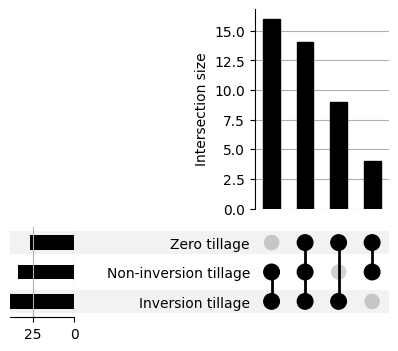

In [28]:
# create pivot table
def createPV(dfdic, dfd, sheet, cols=[], conditions={}):
    """Create pivot table based on a column that contain different values
    per treatments.

    Parameters
    ----------
    dfdic : dict of pandas.DataFrame
        The database.
    dfd : dict of pandas.DataFrame
        Same structure as database but with '1' if the column has different values
        per treatmentIDs.
    sheet : str
        Name of the sheet/tab.
    cols : lit of str, optional
        Name of the columns that might contain different value per Treatment ID.
    conditions : dict, optional
        Pair of column: value.

    Returns
    -------
    dfpv : pandas.DataFrame
        Pivot table with columns being the different values of the column and
        one rows for each experimentID with just True/False for each column.
    expids : list of str
        List of Experiment IDs that have different values per treatmentID for
        the selected column.
    """
    # list of experiment ID that investigate tillage system
    idf = dfd[sheet]
    expids = idf[idf[cols].gt(0).any(axis=1)]['Experiment ID'].tolist()
    df = dfdic[sheet]
    ie = np.ones(df.shape[0], dtype=bool)
    for key in conditions:
        ie = ie & df[key].eq(conditions[key])
    df = df[ie]
    if df.shape[0] == 0:
        print('the conditions filtered out ALL experiments')
        return None, None
    df = df[df['Experiment ID'].isin(expids)].reset_index(drop=True)

    # keep NaN in the grouping by replacing them by string
    #print('{:d}/{:d} NaN values in column of interest (will be dropped)'.format(
    #    df[col].isna().sum(), df.shape[0]))
    #df[col] = df[col].fillna('nan')

    # group by experiment ID and levels of selected column to avoid
    # overcounting (if 3 trt out of 4 use conv. tillage in one experiment:
    # we just want to have 2 trt levels: conv. tillage and no-till)
    df = df.groupby(['Experiment ID'] + cols).count().reset_index()
    #print('{:d} experiments after grouping'.format(df['Experiment ID'].unique().shape[0]))

    # drop experiments with only one level (due to NaN vs other value)
    df['one'] = 1
    dfc = df.groupby('Experiment ID').sum().reset_index()
    print('{:d}/{:d} experiments removed because only one level (NaN vs other)'.format(
        dfc['one'].eq(1).sum(), dfc.shape[0]))
    iout = df['Experiment ID'].isin(dfc[dfc['one'].eq(1)]['Experiment ID'].tolist())
    #print(df[iout][['Experiment ID'] + cols])
    expids = dfc[dfc['one'].gt(1)]['Experiment ID'].tolist()
    df = df[df['Experiment ID'].isin(expids)]

    # creating pivot table with the level in the selected column
    df['one'] = 1
    dfpv = pd.pivot_table(df, values=['one'],
                          index=['Experiment ID'],
                          columns=cols, aggfunc='sum', fill_value=0)
    # fill_value=0 ensure when we do the sum of rows, we don't get NaN (and so can produce a bar chart)
    dfpv = dfpv['one'].reset_index(drop=True)
    if dfpv.eq(2).sum().sum() > 0:
        print('yes it happended! one exp investigate twice smth')

    return dfpv, expids

# test
dfpv, expids = createPV(dfdic, dfd, 'tillage', ['Tillage system'])#, 'Tillage method'])
# creating upset plot (interaction plot)
dfcount = dfpv.set_index(dfpv.columns.tolist())
fig = plt.figure()
_ = UpSet(dfcount, sort_by='cardinality').plot(fig=fig)

# alternative histogram
#fig, ax = plt.subplots()
#df[col].value_counts().plot.bar(ax=ax, ylabel='Number of LTE')

5/48 experiments removed because only one level (NaN vs other)
18/37 experiments removed because only one level (NaN vs other)
3/12 experiments removed because only one level (NaN vs other)
13/24 experiments removed because only one level (NaN vs other)
11/14 experiments removed because only one level (NaN vs other)
0/3 experiments removed because only one level (NaN vs other)
3/73 experiments removed because only one level (NaN vs other)
1/21 experiments removed because only one level (NaN vs other)


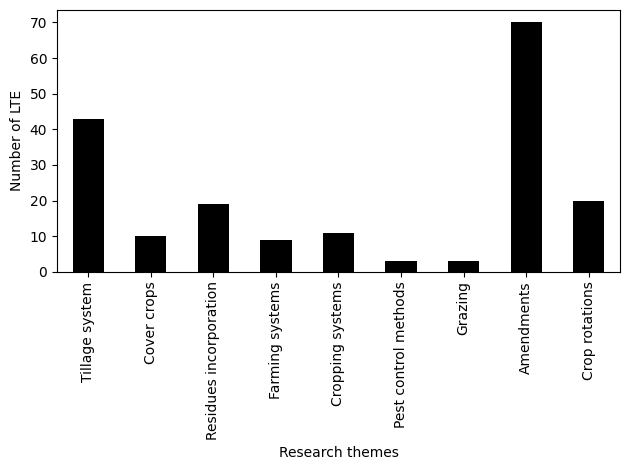

In [29]:
# overview of the research themes (nb of LTE per research themes)
dic = {
    'Tillage system': len(createPV(dfdic, dfd, 'tillage', ['Tillage system'])[1]),
    'Cover crops': len(compdict['cover crop vs no cover crops']['expid'].unique()),
    #'Main crops': len(createPV(dfdic, dfd, 'crops', ['Crop (l1)'],  {'Crop type': 'Main crop'})[1]),
    'Residues incorporation': len(createPV(dfdic, dfd, 'crops', ['Residues incorporation'])[1]),#, 'Residues removal'])
    'Farming systems': len(createPV(dfdic, dfd, 'treatment', ['Farming system'])[1]),
    'Cropping systems': len(createPV(dfdic, dfd, 'crops', ['Cropping system (l0)'])[1]),
    'Pest control methods': len(createPV(dfdic, dfd, 'pest-weed', ['Pest control method'])[1]),
    'Grazing': len(createPV(dfdic, dfd, 'grazing', ['Grazing method (l0)', 'Grazing intensity'])[1]),
    'Amendments': len(createPV(dfdic, dfd, 'amendment', ['Type of fertilizer/amendment (l0)'])[1]),
    'Crop rotations': len(createPV(dfdic, dfd, 'treatment', ['Crop rotation'])[1]),
}
df = pd.DataFrame({'Research themes': dic.keys(),
                   'Number of LTE': dic.values()})
fig, ax = plt.subplots()
df.plot.bar(x='Research themes', y='Number of LTE', ax=ax, color='k',
            ylabel='Number of LTE', legend=False)
fig.tight_layout()
fig.savefig(outputdir + 'rt-overview.jpg', dpi=300)

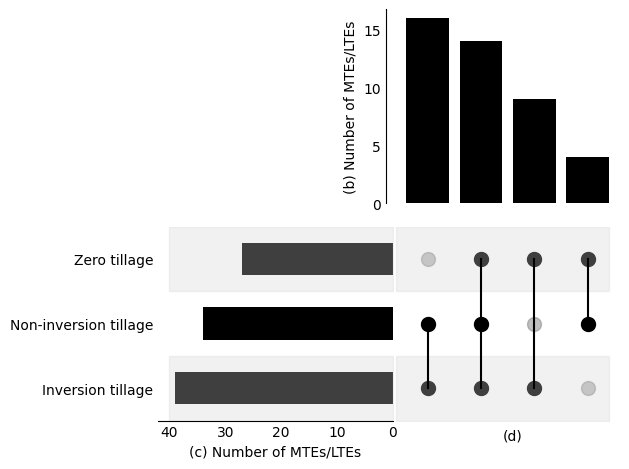

In [30]:
# custom upset plot function rewritten from scratch
# layouting is difficult with the UpsetPlot package as it requires a Figure
# here we reimplement it so we can create subplot that include the three axes
# of the upset plot

def upsetplot(df, axs=[]):
    """Upset plot.

    Parameters
    ----------
    df : pandas.DataFrame
        A pandas dataframe with only boolean columns. Columns title
        will be used as horizontal label.
    axs : list of matplotlib.Axes, optional
        Three axes: intersection, marginal and grid (in this order). If empty,
        will be generated.
    """
    cols = df.columns.tolist()

    # compute marginal
    smarg = df.sum()

    # compute intersection
    df['count'] = 1
    dfi = df.groupby(cols).sum().reset_index()
    dfi = dfi.sort_values('count', ascending=False).reset_index(drop=True)
    ninter = dfi.shape[0]

    if len(axs) != 3:
        fig = plt.figure()
        ax_inter = fig.add_subplot(2, 2, 2)
        ax_marg = fig.add_subplot(2, 2, 3)
        ax_grid = fig.add_subplot(2, 2, 4, sharex=ax_inter, sharey=ax_marg)
    else:
        ax_inter = axs[0]
        ax_marg = axs[1]
        ax_grid = axs[2]

    # intersection bar plot
    #ax_inter.grid(axis='y', zorder=-10)
    ax_inter.bar(np.arange(ninter), dfi['count'], color='k')
    ax_inter.spines['top'].set_visible(False)
    ax_inter.spines['right'].set_visible(False)
    ax_inter.spines['bottom'].set_visible(False)
    #ax_inter.yaxis.set_label_position('right')
    #ax_inter.yaxis.tick_right()
    ax_inter.tick_params(axis=u'both', which=u'both',length=0)
    ax_inter.set_ylabel('(b) Number of MTEs/LTEs')
    #ax_inter.annotate('(b)', (0.95, 0.95), xycoords='axes fraction')
    ax_inter.yaxis.set_major_locator(MultipleLocator(5))

    # grid plot
    gridx, gridy = np.meshgrid(np.arange(ninter), np.arange(len(cols)))
    ax_grid.scatter(gridx, gridy, s=100, color='grey', alpha=0.5)
    iinter = dfi[cols].astype(bool).values.T
    ax_grid.scatter(gridx[iinter], gridy[iinter], s=100, color='k')
    for i in range(iinter.shape[1]):
        if iinter[:, i].sum() > 1:
            ax_grid.plot(gridx[:, i][iinter[:, i]],
                         gridy[:, i][iinter[:, i]], 'k-')
    ax_grid.set_axis_off()
    ylim = ax_grid.get_ylim()
    xlim = ax_grid.get_xlim()
    for i in range(int(np.floor(ylim[1]))+1):
        if i % 2 == 0:
            ax_grid.fill_between(np.arange(*np.sort(xlim)), -0.5 + i, -0.5 + i + 1, color='lightgrey', alpha=0.3)
    ax_grid.annotate('(d)', (0.5, -0.1), xycoords='axes fraction')


    # marginal bar plot
    smarg.plot.barh(ax=ax_marg, color='k')
    #ax_marg.yaxis.set_label_position('right')
    #ax_marg.yaxis.tick_right()
    #ax_marg.tick_params(right=False)
    ax_marg.set_ylabel('')
    ax_marg.set_xlabel('(c) Number of MTEs/LTEs')
    ax_marg.tick_params(axis=u'both', which=u'both',length=0)
    ax_marg.invert_xaxis()
    ax_marg.spines['top'].set_visible(False)
    ax_marg.spines['left'].set_visible(False)
    ax_marg.spines['right'].set_visible(False)
    #ax_marg.annotate('(c)', (-0.05, 1), xycoords='axes fraction')
    ax_marg.xaxis.set_major_locator(MultipleLocator(10))

    #ax_marg.spines['bottom'].set_bounds((0, 50))
    #ax_marg.xaxis.set_ticks_position('bottom')
    #ax_marg.arrow(-1.5, 1, -1.5, 0, fc='k', ec='k',
    #             head_width=1.5, head_length=2)
    #ax_marg.annotate('df', xy=(1.1, 0.5), xycoords='axes fraction',
    #                 xytext=(0.9, 0.49),
    #                arrowprops=dict(arrowstyle='-|>', color='r'))
    
    # add label on the rights instead of ylabels (and so put in the backgroundcolor)
    #labs = smarg.index
    #for i, lab in enumerate(labs):
     #   ax_marg.text(-10, i, lab, color='k')
        #ax_marg.annotate(lab, xy=(-10, i))
        # ISSUE: none of text() or annotate() update the xlim...

    # add bands
    ylim = ax_marg.get_ylim()
    xlim = ax_marg.get_xlim()
    #xlim = (xlim[0], -500)
    for i in range(int(np.floor(ylim[1]))+1):
        if i % 2 == 0:
            ax_marg.fill_between(np.arange(*np.sort(xlim)), -0.5 + i, -0.5 + i + 1, color='lightgrey', alpha=0.3)
    
# test
df = dfpv.copy()
fig = plt.figure()
ax_inter = fig.add_subplot(2, 2, 2)
ax_marg = fig.add_subplot(2, 2, 3)
ax_grid = fig.add_subplot(2, 2, 4, sharex=ax_inter, sharey=ax_marg)
upsetplot(df, axs=[ax_inter, ax_marg, ax_grid])
fig.tight_layout()
fig.subplots_adjust(wspace=-0.03)

### Evolution of research themes

5/48 experiments removed because only one level (NaN vs other)
18/37 experiments removed because only one level (NaN vs other)
3/12 experiments removed because only one level (NaN vs other)
13/24 experiments removed because only one level (NaN vs other)
11/14 experiments removed because only one level (NaN vs other)
0/3 experiments removed because only one level (NaN vs other)
3/73 experiments removed because only one level (NaN vs other)
1/21 experiments removed because only one level (NaN vs other)


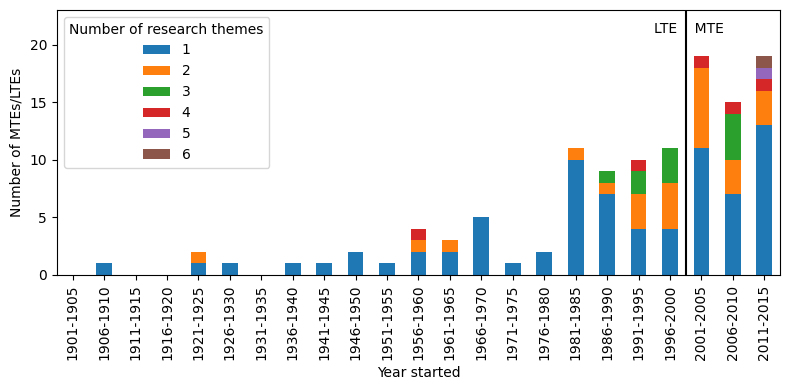

In [31]:
# identification of research theme
dic = {
    'Tillage system': createPV(dfdic, dfd, 'tillage', ['Tillage system'])[1],
    'Cover crops': compdict['cover crop vs no cover crops']['expid'].unique(),
    #'Main crops': len(createPV(dfdic, dfd, 'crops', ['Crop (l1)'],  {'Crop type': 'Main crop'})[1]),
    'Residues incorporation': createPV(dfdic, dfd, 'crops', ['Residues incorporation'])[1],#, 'Residues removal'])
    'Farming systems': createPV(dfdic, dfd, 'treatment', ['Farming system'])[1],
    'Cropping systems': createPV(dfdic, dfd, 'crops', ['Cropping system (l0)'])[1],
    'Pest control methods': createPV(dfdic, dfd, 'pest-weed', ['Pest control method'])[1],
    'Grazing': createPV(dfdic, dfd, 'grazing', ['Grazing method (l0)', 'Grazing intensity'])[1],
    'Amendments': createPV(dfdic, dfd, 'amendment', ['Type of fertilizer/amendment (l0)'])[1],
    'Crop rotations': createPV(dfdic, dfd, 'treatment', ['Crop rotation'])[1],
}
bins = np.arange(1900, 2020, 5)
expids = np.unique(np.hstack([dic[key] for key in dic.keys()]))
df = pd.DataFrame(expids, columns=['expid'])
df2 = dfdic['treatment'][['Experiment ID', 'Year started']].groupby('Experiment ID').first()
df = pd.merge(df, df2, left_on='expid', right_on='Experiment ID', how='left')
for key in dic.keys():
    df[key] = df['expid'].isin(dic[key])
df['sum'] = df[list(dic.keys())].sum(axis=1)
#df['sum'].value_counts().plot.bar()
df['interval'] = pd.cut(df['Year started'], bins=bins)

# create df for stacked bar plot
dfm = pd.concat([df[df['sum'].eq(i)]['interval'].value_counts() for i in np.sort(df['sum'].unique())], axis=1)
dfm.columns = np.sort(df['sum'].unique())
dfm = dfm.sort_index(ascending=True)
fig, ax = plt.subplots(figsize=(8, 4))
dfm.plot.bar(stacked=True, xlabel='Year started', ylabel='Number of MTEs/LTEs', ax=ax)
ax.legend(title='Number of research themes')
xlabs = [a.get_text() for a in ax.get_xticklabels()]
xlabs = [str(int(a[1:5])+1) + '-' + a[-5:-1] for a in xlabs]
ax.set_xticklabels(xlabs)
ax.set_ylim([0, 23])
ax.axvline(19.5, color='k')  # MTE line
ax.text(18.5, 21, 'LTE    MTE')
fig.tight_layout()
fig.savefig(outputdir + 'rt-evolution-combination.jpg', dpi=300)

In [32]:
# which combinations are often studied together
dfc = df.groupby(list(dic.keys())).count().reset_index()
dfc[dfc['sum'].gt(0) & dfc[dic.keys()].sum(axis=1).gt(0)]

,Tillage system,Cover crops,Residues incorporation,Farming systems,Cropping systems,Pest control methods,Grazing,Amendments,Crop rotations,expid,Year started,sum,interval
0,False,False,False,False,False,False,False,False,True,3,3,3,3
1,False,False,False,False,False,False,False,True,False,51,51,51,50
2,False,False,False,False,False,False,False,True,True,1,1,1,1
3,False,False,False,False,False,False,True,False,False,3,3,3,3
4,False,False,False,False,False,True,False,False,True,1,1,1,1
5,False,False,False,False,True,False,False,False,True,1,1,1,1
6,False,False,False,False,True,False,False,True,False,1,1,1,1
7,False,False,False,True,False,False,False,False,False,1,1,1,1
8,False,False,False,True,False,False,False,True,False,1,1,1,1
9,False,False,False,True,False,False,False,True,True,2,2,2,2


3/73 experiments removed because only one level (NaN vs other)
5/48 experiments removed because only one level (NaN vs other)
1/21 experiments removed because only one level (NaN vs other)
18/37 experiments removed because only one level (NaN vs other)
13/24 experiments removed because only one level (NaN vs other)
3/12 experiments removed because only one level (NaN vs other)
11/14 experiments removed because only one level (NaN vs other)
0/3 experiments removed because only one level (NaN vs other)
3/73 experiments removed because only one level (NaN vs other)
Type of fertilizer/amendment (l0)
Inorganic fertilizer       63
Liming material             9
No fertilizer/amendment    53
Organic amendment          49
dtype: int64


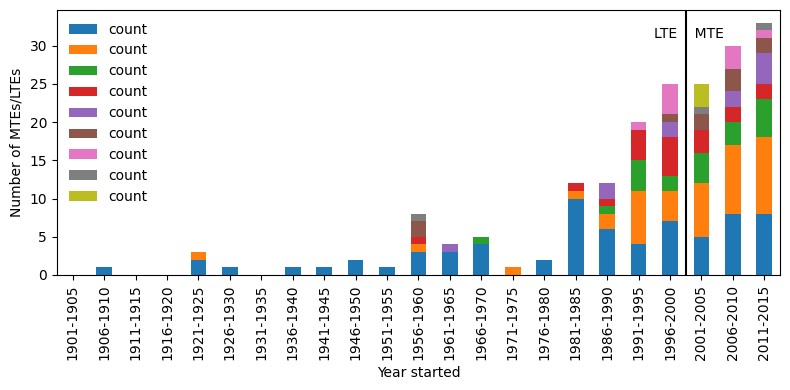

In [34]:
# research themes as a function of start of experiment
def getYearStarted(expids):
    df = dfdic['treatment']
    ie = df['Experiment ID'].isin(expids)
    return df[ie].groupby('Experiment ID').min(numeric_only=True)['Year started'].values

dic = {
    'Amendment (mineral/organic + liming)': getYearStarted(createPV(dfdic, dfd, 'amendment', ['Type of fertilizer/amendment (l0)'])[1]),
    'Tillage system': getYearStarted(createPV(dfdic, dfd, 'tillage', ['Tillage system'])[1]),
    'Crop rotations': getYearStarted(createPV(dfdic, dfd, 'treatment', ['Crop rotation'])[1]),
    'Residues incorporation': getYearStarted(createPV(dfdic, dfd, 'crops', ['Residues incorporation'])[1]),#, 'Residues removal'])
    'Cropping systems': getYearStarted(createPV(dfdic, dfd, 'crops', ['Cropping system (l0)'])[1]),
    'Cover crops': getYearStarted(compdict['cover crop vs no cover crops']['expid'].unique()),
    #'Different main crops': len(createPV(dfdic, dfd, 'crops', ['Crop (l1)'],  {'Crop type': 'Main crop'})[1]),
    'Farming systems': getYearStarted(createPV(dfdic, dfd, 'treatment', ['Farming system'])[1]),
    'Pest control methods': getYearStarted(createPV(dfdic, dfd, 'pest-weed', ['Pest control method'])[1]),
    'Grazing': getYearStarted(createPV(dfdic, dfd, 'grazing', ['Grazing method (l0)', 'Grazing intensity'])[1]),
    
}

# create stacked dataframe with year categories (using pd.cut) and stacked bar chart
bins = np.arange(1900, 2020, 5)
dfm = pd.concat([pd.cut(dic[key], bins=bins).value_counts() for key in dic], axis=1)
dfm = dfm.rename(columns=dict(zip(np.arange(len(dic.keys())),
                                  [a + ' (n={:d})'.format(len(dic[a])) for a in dic.keys()])))
fig, ax = plt.subplots(figsize=(8, 4))
dfm.plot.bar(stacked=True, xlabel='Year started', ylabel='Number of MTEs/LTEs', ax=ax)
ax.legend(framealpha=0, edgecolor='none')
xlabs = [a.get_text() for a in ax.get_xticklabels()]
xlabs = [str(int(a[1:5])+1) + '-' + a[-5:-1] for a in xlabs]
ax.set_xticklabels(xlabs)
ax.axvline(19.5, color='k')  # MTE line
ax.text(18.5, 31, 'LTE    MTE')
fig.tight_layout()
fig.savefig(outputdir + 'rt-evolution.jpg', dpi=300)

print(createPV(dfdic, dfd, 'amendment', ['Type of fertilizer/amendment (l0)'])[0].sum())

### Tillage systems

5/48 experiments removed because only one level (NaN vs other)


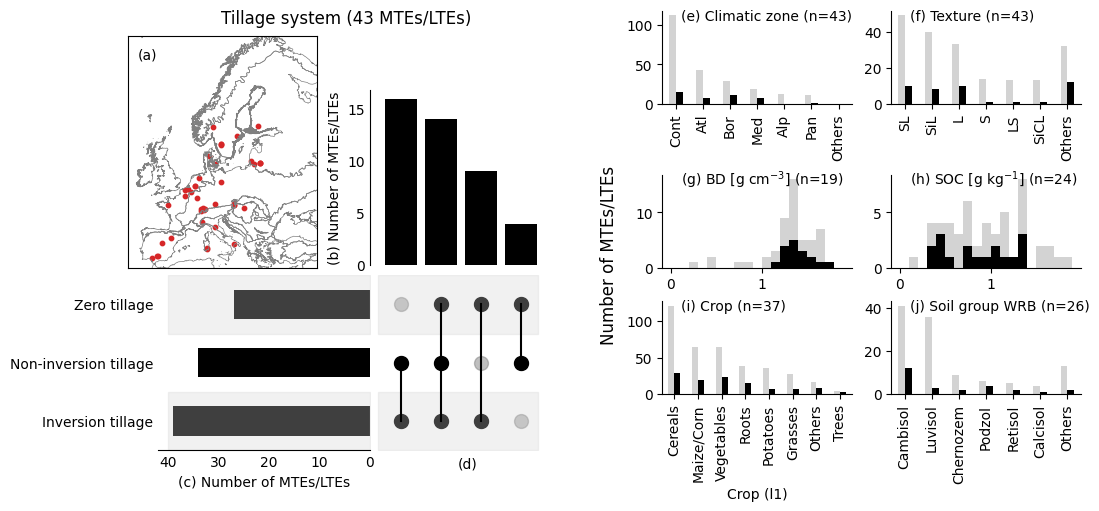

In [36]:
# defining moderator functions

# create dataframe
dfpv, expids = createPV(dfdic, dfd, 'tillage', ['Tillage system'])

# save list
df = pd.DataFrame(expids, columns=['Experiment ID'])

# create figure and gridspec
fig = plt.figure(figsize=(10, 5), layout="constrained")
subfigs = fig.subfigures(1, 2, wspace=0, width_ratios=[1, 1])
subfigs[0].suptitle('Tillage system ({:d} MTEs/LTEs)'.format(len(expids)))

# title and map
ax1 = subfigs[0].add_subplot(2, 2, 1)
def modMap(dfdic, expids, ax, title='', letter='(a)'):
    #ax.set_title('(a)')# {:s} ({:d} MTEs/LTEs)'.format(title, len(expids)))
    m = Basemap(projection='merc', llcrnrlat=35, urcrnrlat=71, 
                    llcrnrlon=-13, urcrnrlon=40, resolution='l', ax=ax)
    #m.drawcoastlines(linewidth=0.5, color='grey')
    #m.drawcountries(linewidth=0.5, color='grey')
    m.readshapefile(datadir + 'biogeo-regions/biogeoRegions2016-epsg4326-simplified', 'enz', color='grey')
    df = dfdic['experiment']
    x, y = m(df['Longitude'], df['Latitude'])
    ie = df['Experiment ID'].isin(expids)
    #m.scatter(x, y, color='lightgrey')
    m.scatter(x[ie], y[ie], s=10, color='tab:red')
    #ax.set_aspect('equal')
    #ax.set_ylabel('a label', rotation=0)
    #ax.yaxis.set_label_position('right')
    ax.annotate(letter, (0.05, 0.9), xycoords='axes fraction')
modMap(dfdic, expids, ax1, 'Tillage system')

# add upset plot
ax_inter = subfigs[0].add_subplot(2, 2, 2)
ax_marg = subfigs[0].add_subplot(2, 2, 3)
ax_grid = subfigs[0].add_subplot(2, 2, 4, sharex=ax_inter, sharey=ax_marg)
upsetplot(dfpv, axs=[ax_inter, ax_marg, ax_grid])
# adjust axes position to merge them for the upset plot
pos0 = ax_grid.get_position()
ax_grid.set_position((pos0.x0, pos0.y0, pos0.width, pos0.height))
pos = ax_inter.get_position()
ax_inter.set_position((pos0.x0, pos0.y0 + pos0.height + 0.02, pos.width, pos.height))
pos = ax_marg.get_position()
ax_marg.set_position((pos.x0, pos0.y0, pos0.x0 - pos.x0, pos.height))

# climatic zone
def modClimate(dfdic, expids, ax, letter='(e)'):
    df = dfdic['experiment'].copy().groupby('Experiment ID').first().reset_index()
    def func(x):
        dic = {
            'Continental': 'Cont',
            'Mediterranean': 'Med',
            'Atlantic': 'Atl',
            'Boreal': 'Bor',
            'Pannonian': 'Pan',
            'Alpine': 'Alp',
            'Anatolian': 'Ana',
            'Steppic': 'Stp',
            'BlackSea': 'BS',
        }
        if pd.isna(x) is False:
            if x in dic.keys():
                return dic[x]
            else:
                return np.nan
        else:
            return np.nan
    df['Climatic zone'] = df['Climatic zone'].apply(func)
    s = df['Climatic zone'].value_counts()
    top = 6  # number of categories to keep
    s2 = pd.concat([s[:top], pd.Series([s[top:].sum()], index=['Others'])])
    keys = s.index.tolist()
    values = s[:top].index.tolist() + ['Others']*(s.shape[0]-top)
    dic = dict(zip(keys, values))
    ie = df['Experiment ID'].isin(expids)
    s3 = df[ie]['Climatic zone'].replace(dic).value_counts()
    sdf = pd.DataFrame([s2, s3]).T.fillna(0)
    sdf.plot.bar(ax=ax, color=['lightgrey', 'k'])
    ax.get_legend().remove()
    #ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.set_yticks([])
    dflte = df[ie].groupby(['Experiment ID'], dropna=False).first().reset_index()
    nlte = dflte['Climatic zone'].notnull().sum()
    ax.annotate(letter + ' Climatic zone (n={:d})'.format(nlte), (0.1, 0.9), xycoords='axes fraction')

# soil texture
def modTexture(dfdic, expids, ax, letter='(f)'):
    df = dfdic['soil-type'].copy().groupby('Experiment ID').first().reset_index()
    def func(x):
        if pd.isna(x) is False:
            return x.replace('(', '').replace(')', '').split(' ')[-1]
        else:
            return x
    df['Soil texture USDA'] = df['Soil texture USDA'].apply(func)
    s = df['Soil texture USDA'].value_counts()
    top = 6  # number of categories to keep
    s2 = pd.concat([s[:top], pd.Series([s[top:].sum()], index=['Others'])])
    keys = s.index.tolist()
    values = s[:top].index.tolist() + ['Others']*(s.shape[0]-top)
    dic = dict(zip(keys, values))
    ie = df['Experiment ID'].isin(expids)
    s3 = df[ie]['Soil texture USDA'].replace(dic).value_counts()
    sdf = pd.DataFrame([s2, s3]).T.fillna(0)
    sdf.plot.bar(ax=ax, color=['lightgrey', 'k'])
    ax.get_legend().remove()
    #ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.set_yticks([])
    dflte = df[ie].groupby(['Experiment ID'], dropna=False).first().reset_index()
    nlte = dflte['Soil texture USDA'].notnull().sum()
    ax.annotate(letter + ' Texture (n={:d})'.format(nlte), (0.1, 0.9), xycoords='axes fraction')

# bulk density
def modBulkDensity(dfdic, expids, ax, letter='(g)'):
    df = dfdic['soil-type']
    df['Soil bulk density (t0)'] = pd.to_numeric(df['Soil bulk density (t0)'], errors='coerce')
    df = df.groupby('Experiment ID').mean(numeric_only=True).reset_index()
    ie = df['Experiment ID'].isin(expids)
    bins=np.arange(0, 2, 0.1)
    df['Soil bulk density (t0)'].plot.hist(bins=bins, ax=ax, color='lightgrey')
    df[ie]['Soil bulk density (t0)'].plot.hist(bins=bins, ax=ax, color='k')
    #ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.set_yticks([])
    ax.set_ylabel('')
    dflte = df[ie].groupby(['Experiment ID'], dropna=False).first().reset_index()
    nlte = dflte['Soil bulk density (t0)'].notnull().sum()
    ax.annotate(letter + ' BD [g cm$^{-3}$]' + ' (n={:d})'.format(nlte), (0.1, 0.9), xycoords='axes fraction')

# soil organic carbon
def modSOC(dfdic, expids, ax, letter='(h)'):
    df = dfdic['soil-type'].copy()
    df['Soil organic carbon (t0)'] = pd.to_numeric(df['Soil organic carbon (t0)'], errors='coerce')
    df = df.groupby('Experiment ID').mean(numeric_only=True).reset_index()
    ie = df['Experiment ID'].isin(expids)
    bins=np.arange(0, 2, 0.1)
    df['Soil organic carbon (t0)'].plot.hist(bins=bins, ax=ax, color='lightgrey')
    df[ie]['Soil organic carbon (t0)'].plot.hist(bins=bins, ax=ax, color='k')
    #ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.set_yticks([])
    ax.set_ylabel('')
    dflte = df[ie].groupby(['Experiment ID'], dropna=False).first().reset_index()
    nlte = dflte['Soil organic carbon (t0)'].notnull().sum()
    ax.annotate(letter + ' SOC [g kg$^{-1}$]' + ' (n={:d})'.format(nlte), (0.1, 0.9), xycoords='axes fraction')

# main crop type
def modCrop(dfdic, expids, ax, letter='(i)'):
    df = dfdic['crops'].copy()
    df = df[df['Crop type'].eq('Main crop')]
    notindic = []
    def classCrop(x):
        global cropdic
        if x in cropdic:
            return cropdic[x]
        else:
            notindic.append(x)
            return 'Others'
    df['Crop (l1)'] = df['Crop (l1)'].apply(classCrop)
    if len(notindic) > 0:
        print('missing from cropdic:', np.unique(notindic).tolist())
    df = df.groupby(['Experiment ID', 'Crop (l1)']).first().reset_index() 
    s = df['Crop (l1)'].value_counts()
    ie = df['Experiment ID'].isin(expids)
    s3 = df[ie]['Crop (l1)'].value_counts()
    sdf = pd.DataFrame([s, s3]).T.fillna(0)
    sdf.plot.bar(ax=ax, color=['lightgrey', 'k'])
    ax.get_legend().remove()
    #ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.set_yticks([])
    dflte = df[ie].groupby(['Experiment ID'], dropna=False).first().reset_index()
    nlte = dflte['Crop (l1)'].notnull().sum()
    ax.annotate(letter + ' Crop (n={:d})'.format(nlte), (0.1, 0.9), xycoords='axes fraction')

# soil type WRB
def modWRB(dfdic, expids, ax, letter='(j)'):
    df = dfdic['soil-type'].copy().groupby('Experiment ID').first().reset_index()
    s = df['Soil group WRB'].value_counts()
    top = 6  # number of categories to keep
    s2 = pd.concat([s[:top], pd.Series([s[top:].sum()], index=['Others'])])
    keys = s.index.tolist()
    values = s[:top].index.tolist() + ['Others']*(s.shape[0]-top)
    dic = dict(zip(keys, values))
    ie = df['Experiment ID'].isin(expids)
    s3 = df[ie]['Soil group WRB'].replace(dic).value_counts()
    sdf = pd.DataFrame([s2, s3]).T.fillna(0)
    sdf.plot.bar(ax=ax, color=['lightgrey', 'k'])
    ax.get_legend().remove()
    #ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.set_yticks([])
    dflte = df[ie].groupby(['Experiment ID'], dropna=False).first().reset_index()
    nlte = dflte['Soil group WRB'].notnull().sum()
    ax.annotate(letter + ' Soil group WRB (n={:d})'.format(nlte), (0.1, 0.9), xycoords='axes fraction')

# add moderators
axs1 = subfigs[1].subplots(3, 2)
modClimate(dfdic, expids, axs1[0, 0])
modTexture(dfdic, expids, axs1[0, 1])
modBulkDensity(dfdic, expids, axs1[1, 0])
modSOC(dfdic, expids, axs1[1, 1])
modCrop(dfdic, expids, axs1[2, 0])
modWRB(dfdic, expids, axs1[2, 1])
subfigs[1].supylabel('Number of MTEs/LTEs')


fig.savefig(outputdir + 'dash-tillage-systems.jpg', bbox_inches='tight', dpi=500)

### Amendments

3/73 experiments removed because only one level (NaN vs other)


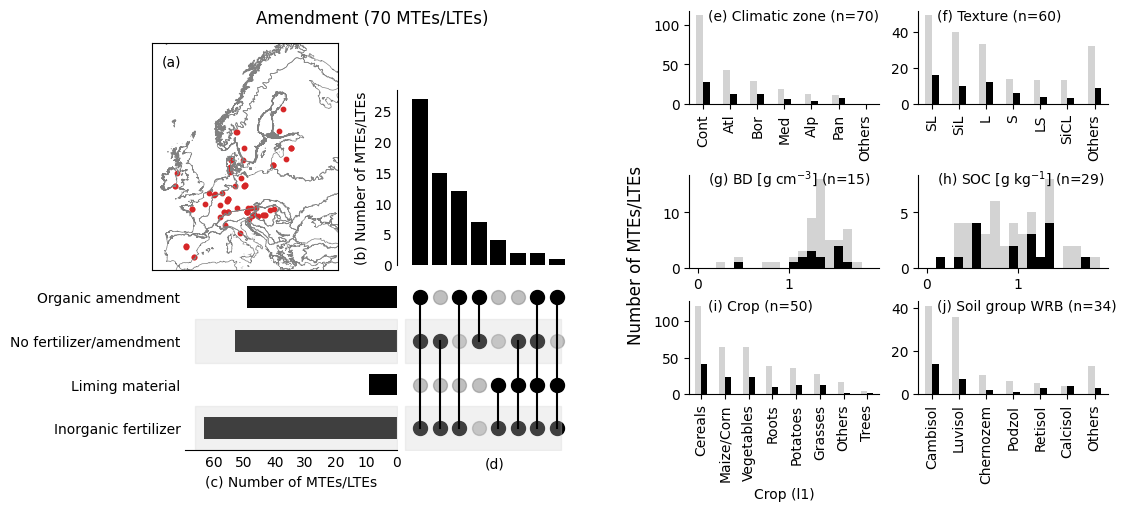

In [37]:
# different amendment

# create dataframe
dfpv, expids = createPV(dfdic, dfd, 'amendment', ['Type of fertilizer/amendment (l0)'])

# save list
df = pd.DataFrame(expids, columns=['Experiment ID'])

# figure
fig = plt.figure(figsize=(10, 5), layout="constrained")
subfigs = fig.subfigures(1, 2, wspace=0, width_ratios=[1, 1])
subfigs[0].suptitle('Amendment ({:d} MTEs/LTEs)'.format(len(expids)))

# title and map
ax1 = fig.add_subplot(2, 2, 1)
modMap(dfdic, expids, ax1, title='Amendment')

# add upset plot
ax_inter = subfigs[0].add_subplot(2, 2, 2)
ax_marg = subfigs[0].add_subplot(2, 2, 3)
ax_grid = subfigs[0].add_subplot(2, 2, 4, sharex=ax_inter, sharey=ax_marg)
upsetplot(dfpv, axs=[ax_inter, ax_marg, ax_grid])
# adjust axes position to merge them for the upset plot
pos0 = ax_grid.get_position()
ax_grid.set_position((pos0.x0, pos0.y0, pos0.width, pos0.height))
pos = ax_inter.get_position()
ax_inter.set_position((pos0.x0, pos0.y0 + pos0.height + 0.02, pos.width, pos.height))
pos = ax_marg.get_position()
ax_marg.set_position((pos.x0, pos0.y0, pos0.x0 - pos.x0, pos.height))

# add moderators
axs1 = subfigs[1].subplots(3, 2)
modClimate(dfdic, expids, axs1[0, 0])
modTexture(dfdic, expids, axs1[0, 1])
modBulkDensity(dfdic, expids, axs1[1, 0])
modSOC(dfdic, expids, axs1[1, 1])
modCrop(dfdic, expids, axs1[2, 0])
modWRB(dfdic, expids, axs1[2, 1])
subfigs[1].supylabel('Number of MTEs/LTEs')

# adjust map axis
pos = ax1.get_position()
ax1.set_position((pos.x0 - 0.25, pos.y0-0.06, pos.width*2, pos.height*1.3))


fig.savefig(outputdir + 'dash-amendment.jpg', bbox_inches='tight', dpi=500)

### Residues management

7/42 experiments removed because only one level (NaN vs other)


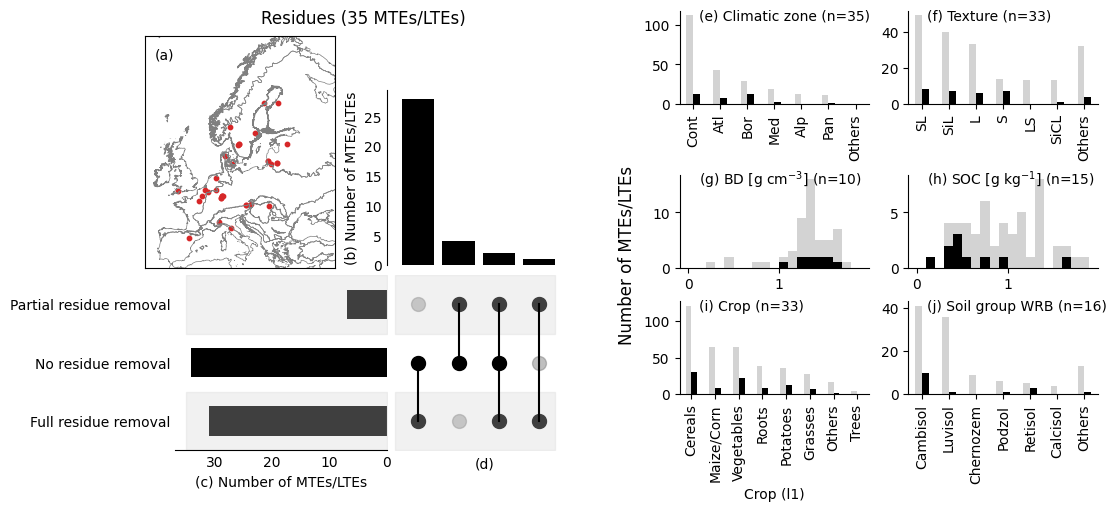

In [38]:
# different residue management

# create dataframe
dfpv, expids = createPV(dfdic, dfd, 'crops', ['Residues removal']) # Residue incorporation

# save list
df = pd.DataFrame(expids, columns=['Experiment ID'])

# figure
fig = plt.figure(figsize=(10, 5), layout="constrained")
subfigs = fig.subfigures(1, 2, wspace=0, width_ratios=[1, 1])
subfigs[0].suptitle('Residues ({:d} MTEs/LTEs)'.format(len(expids)))

# title and map
modMap(dfdic, expids, subfigs[0].add_subplot(2, 2, 1), title='Residues')

# add upset plot
ax_inter = subfigs[0].add_subplot(2, 2, 2)
ax_marg = subfigs[0].add_subplot(2, 2, 3)
ax_grid = subfigs[0].add_subplot(2, 2, 4, sharex=ax_inter, sharey=ax_marg)
upsetplot(dfpv, axs=[ax_inter, ax_marg, ax_grid])
# adjust axes position to merge them for the upset plot
pos0 = ax_grid.get_position()
ax_grid.set_position((pos0.x0, pos0.y0, pos0.width, pos0.height))
pos = ax_inter.get_position()
ax_inter.set_position((pos0.x0, pos0.y0 + pos0.height + 0.02, pos.width, pos.height))
pos = ax_marg.get_position()
ax_marg.set_position((pos.x0, pos0.y0, pos0.x0 - pos.x0, pos.height))

# add moderators
axs1 = subfigs[1].subplots(3, 2)
modClimate(dfdic, expids, axs1[0, 0])
modTexture(dfdic, expids, axs1[0, 1])
modBulkDensity(dfdic, expids, axs1[1, 0])
modSOC(dfdic, expids, axs1[1, 1])
modCrop(dfdic, expids, axs1[2, 0])
modWRB(dfdic, expids, axs1[2, 1])
subfigs[1].supylabel('Number of MTEs/LTEs')

fig.savefig(outputdir + 'dash-residues.jpg', dpi=500, bbox_inches='tight')

### Cropping systems

13/24 experiments removed because only one level (NaN vs other)


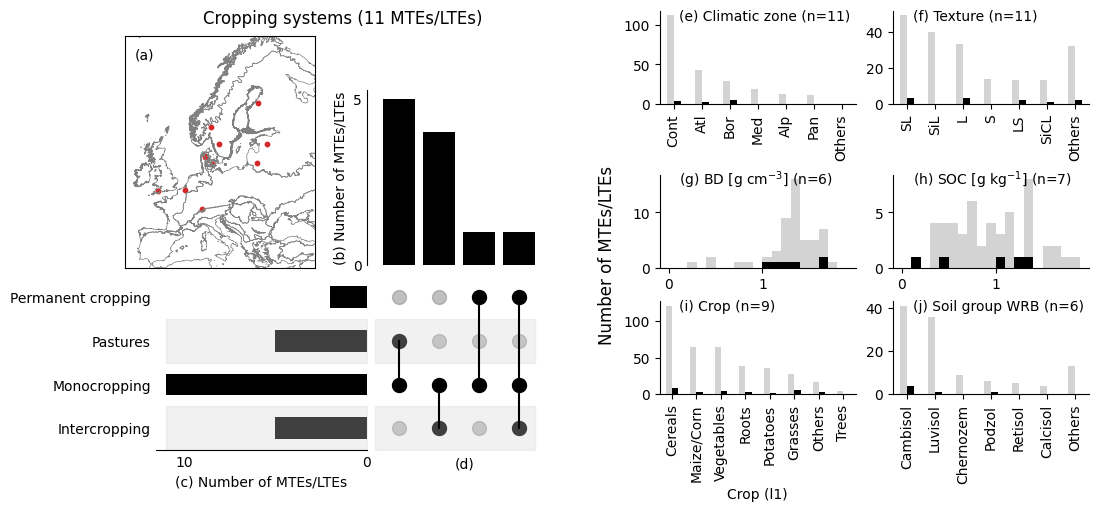

In [39]:
# different cropping systems

# create dataframe
dfpv, expids = createPV(dfdic, dfd, 'crops', ['Cropping system (l0)'])

# save list
df = pd.DataFrame(expids, columns=['Experiment ID'])

# figure
fig = plt.figure(figsize=(10, 5), layout="constrained")
subfigs = fig.subfigures(1, 2, wspace=0, width_ratios=[1, 1])
subfigs[0].suptitle('Cropping systems ({:d} MTEs/LTEs)'.format(len(expids)))

# title and map
ax1 = subfigs[0].add_subplot(2, 2, 1)
modMap(dfdic, expids, ax1, title='Cropping systems')

# add upset plot
ax_inter = subfigs[0].add_subplot(2, 2, 2)
ax_marg = subfigs[0].add_subplot(2, 2, 3)
ax_grid = subfigs[0].add_subplot(2, 2, 4, sharex=ax_inter, sharey=ax_marg)
upsetplot(dfpv, axs=[ax_inter, ax_marg, ax_grid])
# adjust axes position to merge them for the upset plot
pos0 = ax_grid.get_position()
ax_grid.set_position((pos0.x0, pos0.y0, pos0.width, pos0.height))
pos = ax_inter.get_position()
ax_inter.set_position((pos0.x0, pos0.y0 + pos0.height + 0.02, pos.width, pos.height))
pos = ax_marg.get_position()
ax_marg.set_position((pos.x0, pos0.y0, pos0.x0 - pos.x0, pos.height))

# add moderators
axs1 = subfigs[1].subplots(3, 2)
modClimate(dfdic, expids, axs1[0, 0])
modTexture(dfdic, expids, axs1[0, 1])
modBulkDensity(dfdic, expids, axs1[1, 0])
modSOC(dfdic, expids, axs1[1, 1])
modCrop(dfdic, expids, axs1[2, 0])
modWRB(dfdic, expids, axs1[2, 1])
subfigs[1].supylabel('Number of MTEs/LTEs')

fig.savefig(outputdir + 'dash-cropping-systems.jpg', dpi=500, bbox_inches='tight')

### Cover crops

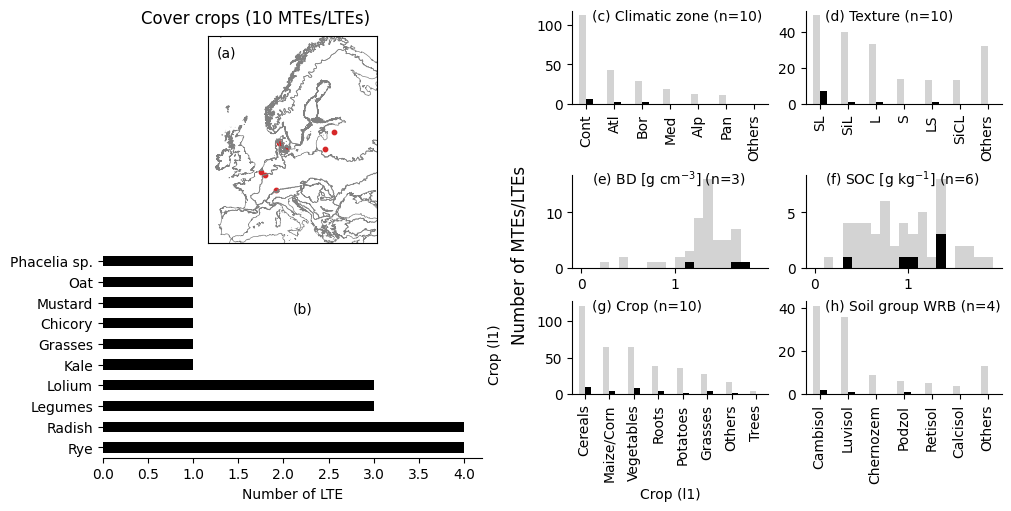

In [40]:
# presence vs absence of cover crops
# create list of expids
expids = compdict['cover crop vs no cover crops']['expid'].unique()

# save list
df = pd.DataFrame(expids, columns=['Experiment ID'])

# figure
fig = plt.figure(figsize=(10, 5), layout="constrained")
subfigs = fig.subfigures(1, 2, wspace=0, width_ratios=[1, 1])
subfigs[0].suptitle('Cover crops ({:d} MTEs/LTEs)'.format(len(expids)))

# title and map
ax1 = subfigs[0].add_subplot(2, 1, 1)
modMap(dfdic, expids, ax1, title='Cover crops')

# add barplot
ax = subfigs[0].add_subplot(2, 1, 2)
df = dfdic['crops']
df = df[df['Experiment ID'].isin(expids)]
df = df[df['Crop type'].ne('Main crop')]
df = df.groupby(['Experiment ID', 'Crop (l1)']).first().reset_index()
df['Crop (l1)'] = df['Crop (l1)'].apply(cleanArrow).apply(lambda x: x.split('/')[0])
s = df['Crop (l1)'].value_counts()
s.plot.barh(ax=ax, color='k')
ax.yaxis.set_label_position('right')
#ax.yaxis.tick_right()
#ax.invert_yaxis()
#ax.tick_params(axis=u'both', which=u'both',length=0)
#ax.invert_xaxis()
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.annotate('(b)', xy=(0.5, 0.7), xycoords='axes fraction')
ax.set_xlabel('Number of LTE')

# add moderators
axs1 = subfigs[1].subplots(3, 2)
modClimate(dfdic, expids, axs1[0, 0], '(c)')
modTexture(dfdic, expids, axs1[0, 1], '(d)')
modBulkDensity(dfdic, expids, axs1[1, 0], '(e)')
modSOC(dfdic, expids, axs1[1, 1], '(f)')
modCrop(dfdic, expids, axs1[2, 0], '(g)')
modWRB(dfdic, expids, axs1[2, 1], '(h)')
subfigs[1].supylabel('Number of MTEs/LTEs')

fig.savefig(outputdir + 'dash-cover-crops.jpg', dpi=500, bbox_inches='tight')

### Crop rotation

1/21 experiments removed because only one level (NaN vs other)


Text(0, 0.5, 'Number of MTEs/LTEs')

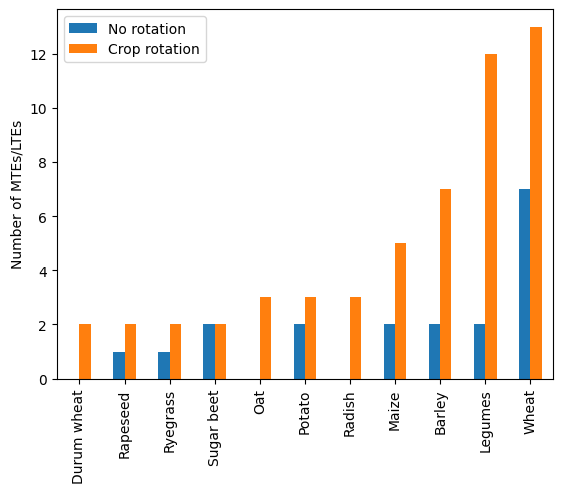

In [41]:
# identify crop sucession
dfpv, expids = createPV(dfdic, dfd, 'treatment', ['Crop rotation'])

norotcrop = []
rotcrop = []
for expid in expids:
    dftrt = dfdic['treatment']
    # no rotation
    ie = dftrt['Experiment ID'].eq(expid) & dftrt['Crop rotation'].eq('No rotation')
    treatids = dftrt[ie]['Treatment ID'].values
    crops = []
    for treatid in treatids:
        df = dfdic['crops']
        ie = df['Experiment ID'].eq(expid) & df['Treatment ID'].eq(treatid)
        sdf = df[ie]
        if sdf.shape[0] > 0:
            crops += list(sdf['Crop (l1)'].unique())
            #print(expid, treatid, sdf['Crop'].unique())
    norotcrop += list(np.unique(crops))

    # rotation
    ie = dftrt['Experiment ID'].eq(expid) & dftrt['Crop rotation'].eq('Crop rotation')
    treatids = dftrt[ie]['Treatment ID'].values
    crops = []
    for treatid in treatids:
        df = dfdic['crops']
        ie = df['Experiment ID'].eq(expid) & df['Treatment ID'].eq(treatid)
        sdf = df[ie]
        if sdf.shape[0] > 0:
            crops += list(sdf['Crop (l1)'].unique())
            #print(expid, treatid, sdf['Crop'].unique())
    rotcrop += list(np.unique(crops))

def cleanLabel(x):
    if x == '> Lolium/Ryegrass':
        x = '> Ryegrass/Lolium'
    elif x == 'nan':
        return pd.NA
    x = cleanArrow(x)
    return x.split('/')[0]
    
snorot = pd.Series(norotcrop).dropna().apply(cleanLabel).dropna()
srot = pd.Series(rotcrop).dropna().apply(cleanLabel).dropna()

df = pd.DataFrame({'norotation': snorot.value_counts(),
                   'rotation': srot.value_counts()})
ie = ~((df['norotation'].isna() & df['rotation'].lt(2))
      | (df['norotation'].lt(2) & df['rotation'].isna())
      | (df['norotation'].lt(2) & df['rotation'].lt(2)))
dfcr = df[ie].sort_values('rotation')

fig, ax = plt.subplots()
dfcr.plot.bar(ax=ax)
ax.legend(['No rotation', 'Crop rotation'])
ax.set_ylabel('Number of MTEs/LTEs')

1/21 experiments removed because only one level (NaN vs other)


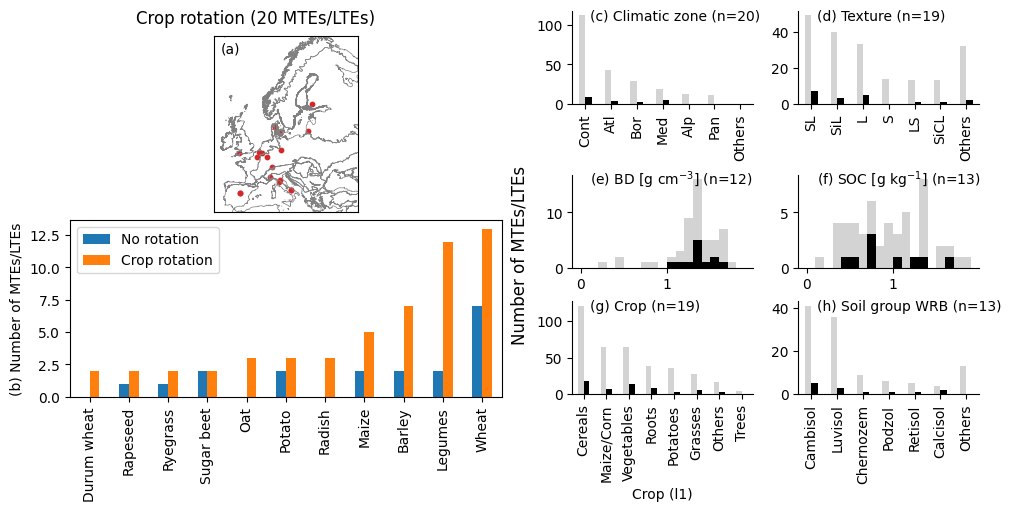

In [42]:
# crop rotation

# create dataframe
dfpv, expids = createPV(dfdic, dfd, 'treatment', ['Crop rotation'])

# save list
df = pd.DataFrame(expids, columns=['Experiment ID'])

# figure
fig = plt.figure(figsize=(10, 5), layout="constrained")
subfigs = fig.subfigures(1, 2, wspace=0, width_ratios=[1, 1])
subfigs[0].suptitle('Crop rotation ({:d} MTEs/LTEs)'.format(len(expids)))

# title and map
ax1 = subfigs[0].add_subplot(2, 1, 1)
modMap(dfdic, expids, ax1, title='Cover rotation')

# crops used for both rotation and no rotation
ax = subfigs[0].add_subplot(2, 1, 2)
dfcr.plot.bar(ax=ax)
ax.legend(['No rotation', 'Crop rotation'])
ax.set_ylabel('(b) Number of MTEs/LTEs')

# add moderators
axs1 = subfigs[1].subplots(3, 2)
modClimate(dfdic, expids, axs1[0, 0], '(c)')
modTexture(dfdic, expids, axs1[0, 1], '(d)')
modBulkDensity(dfdic, expids, axs1[1, 0], '(e)')
modSOC(dfdic, expids, axs1[1, 1], '(f)')
modCrop(dfdic, expids, axs1[2, 0], '(g)')
modWRB(dfdic, expids, axs1[2, 1], '(h)')
subfigs[1].supylabel('Number of MTEs/LTEs')

fig.savefig(outputdir + 'dash-crop-rotation.jpg', dpi=500)